# *Monod* demonstration: fit to neural cell types

lol I need to rewrite this

## Metadata and prerequisites

In [1]:
import time
t1 = time.time()

Define the dataset metadata and disk locations.

In [2]:
subcluster_names = ['l23it','l5it','l6it', 'l56np', 'l6ct']
dataset_names = ['allen_B08_'+y  for y in subcluster_names] 
loom_filepaths = ['/home/ggorin/count_data/loom_allen_celltype_kb/test/'+x+'.loom' for x in dataset_names] 

transcriptome_filepath = '/home/ggorin/projects/seq-cme-technoise/polyA_ref/gg_200524_mouse_genome_polyA_cum_1'
attribute_names=['spliced','unspliced','gene_name','barcode']

In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')
import monod
from monod.preprocess import *
from monod.extract_data import extract_data
import monod.cme_toolbox as cme_toolbox
from monod.cme_toolbox import CMEModel
import monod.inference as inference
from monod.inference import InferenceParameters, GradientInference
import monod.analysis as analysis
from monod.analysis import *

## Helper functions

In [29]:
def get_MoM(U,S):
    raw_guess = np.zeros(4)
    Um = U.mean()
    Uv = U.var()
    Sm = S.mean()
    Sv = S.var()

    beta = 1/Um #assuming <k>=1
    gamma = 1/Sm
    kappa = beta / ( (Sv - Sm)/(Uv - Um) * Um * (beta + gamma) / (Sm*beta) - 1) - gamma
    theta = (kappa+beta)/Um * (Uv - Um)
    
    a = kappa/theta
    
    raw_guess = np.asarray([beta,gamma,kappa,theta])/a
    
    return raw_guess

def get_MLE(model,U,S,reduced_guess=None,disp=True,limit='fast',n_restarts = 4,maxiter=10):
    data = np.unique(np.vstack((U,S)).astype(int),\
                     axis=1,return_counts=True)
    
    
    phys_lb = np.asarray([-2]*4)+np.random.randn(4)*0.02
    phys_ub = np.asarray([2]*4)+np.random.randn(4)*0.02
    phys_lb_raw = 10**phys_lb
    phys_ub_raw = 10**phys_ub
    
    initial_guess = np.zeros(4)
    if reduced_guess is not None:
        raw_guess = 10**reduced_guess
        if limit=='fast':
            initial_guess[0] = raw_guess[1] #beta
            initial_guess[1] = raw_guess[2] #gamma
            initial_guess[2] = 5.9 #kappa -- must be pretty fast
            initial_guess[3] = raw_guess[0]*initial_guess[2] #theta
        elif limit=='slow':
            initial_guess[2] = 1/raw_guess[0] #alpha=a/kappa, a set to 1
            initial_guess[3] = 4 #theta: arbitary
            initial_guess[0] = raw_guess[1]*initial_guess[3] #beta
            initial_guess[1] = raw_guess[2]*initial_guess[3] #gamma
    else:
        raw_guess = get_MoM(U,S)
        initial_guess = np.clip(raw_guess,phys_lb_raw,phys_ub_raw)
    log_initial_guess = np.log10(initial_guess)
    
    if model=='CIR':
        pssfun = get_CIR_2sp
    if model=='GOU':
        pssfun = get_GOU_2sp
        
    err = np.inf
    err_thr = 0.99
    if n_restarts>0:
        for restart in range(n_restarts):
            if restart>0:
                log_initial_guess = np.random.rand(4) * (phys_ub-phys_lb) + phys_lb
            grad_bnd=scipy.optimize.Bounds(phys_lb,phys_ub)
            res_arr = scipy.optimize.minimize(lambda x: get_kld(x,pssfun,data),
                                x0=log_initial_guess, \
                                bounds=grad_bnd,\
                                options={'maxiter':maxiter,'disp':disp})
            if res_arr.fun<err*err_thr:
                x=res_arr.x
                err=res_arr.fun
        return x
    else:
        return log_initial_guess
    
    
def convert_pars(pars): #go from log10 4 parameters to raw 5 parameters
    raw_pars = 10**pars
    pars_sde = np.zeros(5)
    pars_sde[0] = raw_pars[0] #beta
    pars_sde[1] = raw_pars[1] #gamma
    pars_sde[2] = 1
    pars_sde[3] = raw_pars[2] #kappa
    pars_sde[4] = raw_pars[3] #theta
    return pars_sde

def get_lik_ratio(pars_gou,pars_cir,U,S,EPS=1e-15):
    data = np.unique(np.vstack((U,S)).astype(int),\
                     axis=1,return_counts=True)
    unique_values, counts = data
    coords = tuple([tuple(x) for x in unique_values.T])
    mx = unique_values.max(1)+10
    pss_gou = get_GOU_2sp(np.copy(mx),pars_gou)
    pss_cir = get_CIR_2sp(np.copy(mx),pars_cir)
    
    pss_gou[pss_gou<EPS] = EPS
    pss_gou = [pss_gou[x] for x in coords]
    pss_cir[pss_cir<EPS] = EPS
    pss_cir = [pss_cir[x] for x in coords]
    logL_gou = (counts * np.log(pss_gou)).sum()
    logL_cir = (counts * np.log(pss_cir)).sum()
    lik_ratio = logL_cir - logL_gou
    return lik_ratio, logL_gou, logL_cir
    
    

def get_kld(pars,pssfun,data,EPS=1e-15):
    unique_values, counts = data
    mx = unique_values.max(1)+10
    proposal_probabilities = pssfun(np.copy(mx),convert_pars(pars))
    proposal_probabilities[proposal_probabilities<EPS] = EPS
    coords = tuple([tuple(x) for x in unique_values.T])
    proposal_probabilities = [proposal_probabilities[x] for x in coords]
    kld = counts * np.log(counts / proposal_probabilities)
    return np.sum(kld)


from numpy.fft import irfftn
x_gauss,w_gauss = scipy.special.roots_legendre(60, mu=False)

def get_gf_GOU_2sp_ODE(g0, g1, params):
    beta_0, beta_1, a, kappa, theta = params     # get parameters
    
    c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g1)   
    
    min_fudge, max_fudge = 1, 10                                     # Determine integration time scale / length
    dt = np.min([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*min_fudge
    t_max = np.max([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*max_fudge
    num_tsteps = int(np.ceil(t_max/dt))
    
#     t_array = np.linspace(0, t_max, num_tsteps+1)
#     t_array = t_array.reshape((1, num_tsteps + 1))
    t_array = (t_max*(x_gauss+1)/2)[None,:]
    
    q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    c0 = c0.reshape((c0.shape[0],1))
    c1 = c1.reshape((c1.shape[0],1))

    q0 = theta*c0*(np.exp(-beta_0*t_array) - np.exp(-kappa*t_array))/(kappa - beta_0) 
    q1 = theta*c1*(np.exp(-beta_1*t_array) - np.exp(-kappa*t_array))/(kappa - beta_1)
    q = q0 + q1
    

    integrand = q/(1-q)
    
#     print(integrand.shape)
#     print(w_gauss.shape)
    integral=np.matmul(integrand,w_gauss[:,None]).sum(1)/2*t_max
#     integral = np.trapz(integrand, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp( a*integral)               # get generating function
    return gf


# Get Pss for 2 species GOU model via ODE method
def get_GOU_2sp(mx, params):
    # Get generating function argument
    u = []
    half = np.copy(mx[:])
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    gf = get_gf_GOU_2sp_ODE(g[0], g[1], params)                    
    gf = gf.reshape(tuple(half))
    
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss


# ODE for 2 species CIR model
def f_2sp(q, t, c0, c1, params):
    beta_0, beta_1, a, kappa, theta = params
    result = - kappa*q + theta*q*q + kappa*( c0*np.exp(-beta_0*t) + c1*np.exp(-beta_1*t)  ) 
    return result


# Vectorized RK4 implementation for 2 species CIR model
def RK4_2sp(q, f, t, c0, c1, step_size, param):
    j1 = f(q, t, c0, c1, param)
    j2 = f(q + (step_size/2)*j1, t + (step_size/2), c0, c1, param)   
    j3 = f(q + (step_size/2)*j2, t + (step_size/2), c0, c1, param)   
    j4 = f(q + (step_size)*j3, t + (step_size), c0, c1, param)  
    
    q_new = q + (step_size/6)*(j1 + 2*j2 + 2*j3 + j4)
    return q_new


# Get 2 species CIR generating function using ODE method
def get_gf_CIR_2sp(g0, g1, params):
#     print('in pgf routine')
    beta_0, beta_1, a, kappa, theta = params     # get parameters
    
    c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g1)   

    t_max = (1/np.asarray(params)).max()*5   
    c0 = c0[:,None]
    c1 = c1[:,None]
    t_eval = t_max*(x_gauss+1)/2
    def intfun_(t,y):
        return f_2sp(y, t, c0, c1, params)
    rk = scipy.integrate.solve_ivp(fun=intfun_,t_span=[0,t_max],y0=np.zeros((g0.shape[0]), dtype=np.complex64),t_eval = t_eval,
                              vectorized=True)
    try:
        integral = np.matmul(rk.y,w_gauss[:,None]).sum(1)/2*t_max
    except:
        print('falling back on jjv solution')
        min_fudge, max_fudge = 0.5, 10                                     # Determine integration time scale / length
        dt = np.min([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*min_fudge
        num_tsteps = int(np.ceil(t_max/dt))
        q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE

        # Solve ODE using RK4 method 
        for i in range(0, num_tsteps):
            t = i*dt
            q[:,i+1] = RK4_2sp(q[:,i], f_2sp, t, c0[:,0], c1[:,0], dt, params)

        integral = np.trapz(q, dx=dt, axis=1)     # integrate ODE solution
        if (~np.isfinite(integral)).any():
            print('Procedure failed.')
            print(params)
            print(rk.y.shape)
            print(w_gauss[:,None].shape)
            print(t_eval.shape)
            print(x_gauss.shape)
            print(t_max)
            
    gf = np.exp((a*theta/kappa)*integral)               # get generating function
    return gf


# Get Pss for 2 species CIR model via ODE method
def get_CIR_2sp(mx, params):
    # Get generating function argument
    u = []
    half = np.copy(mx[:])
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    gf = get_gf_CIR_2sp(g[0], g[1], params)                    
    gf = gf.reshape(tuple(half))
                              
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss


In [28]:
w_gauss.sum()

2.000000000000001

## Preprocessing

Construct a batch by finding 3,000 genes which have at least moderate expression across all datasets. Visualize the set of genes (purple) that meet the expression filtering criteria.

In [35]:
dir_string,dataset_strings = construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='allen_celltypes',batch_id=1,\
                                             n_genes=3000,viz=False)

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Dataset: allen_B08_l23it
INFO:root:621 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:5864 genes retained after expression filter.
INFO:root:Dataset: allen_B08_l5it
INFO:root:1702 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:6759 genes retained after expression filter.
INFO:root:Dataset: allen_B08_l6it
INFO:root:471 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:5773 genes retained after expression filter.
INFO:root:Dataset: allen_B08_l56np
INFO:root:191 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:4268 genes retained after expression filter.
INFO:root:Dataset: allen_B08_l6ct
INFO:root:1359 cells detected.
INFO:root:32285 features observed, 32005 match genome anno

Define the models to analyze.

In [36]:
models = ('Bursty','CIR','Extrinsic')

In [37]:
n_models = len(models)
n_datasets = len(dataset_names)

## Inference

Define parameter bounds, then iterate over datasets and models and perform the fits.

This is easily parallelized.

In [39]:
# lb = [[-2.0, -2, -2],
#       [-2.0, -1.8, -1.8],
#       [-2.0, -1.8, -1.8]]
# ub = [[4.2, 2.5, 3.5],
#       [4.2, 2.5, 3.5],
#       [4.2, 2.5, 3.5]]
# grid = [1,1]

def par_fun(x):
    models = ('Bursty','CIR','Extrinsic')
    n_models = len(models)
    fp,tx,dn,ds,dirs,att = x
    print(x[0])
    for j in range(n_models):
        print(models[j])
        fitmodel = CMEModel(models[j],'None')
        inference_parameters = InferenceParameters([-2.0, -2.0, -2.0],[4.2, 2.5, 3.5],[1,1],[1,1],[1,1],\
                    ds,fitmodel,use_lengths = False,
                    gradient_params = {'max_iterations':10,'init_pattern':'moments','num_restarts':1})
        if j==0:
            search_data = extract_data(fp,tx,dn,
                                ds,dirs,dataset_attr_names=att)
        else:
            search_data = load_search_data(ds+'/raw.sd')
        full_result_string = inference_parameters.fit_all_grid_points(1,search_data)
        result_strings.append(full_result_string)
    return result_strings
try:
    pool = multiprocessing.Pool(processes=5)
    iterable = zip(loom_filepaths,[transcriptome_filepath]*n_datasets,dataset_names,dataset_strings,\
        [dir_string]*n_datasets,[attribute_names]*n_datasets)
    result_strings = pool.map(par_fun, iterable)
    pool.close()
    pool.join()
except:
    pool.terminate()
    pool.join()


/home/ggorin/count_data/loom_allen_celltype_kb/test/allen_B08_l5it.loom/home/ggorin/count_data/loom_allen_celltype_kb/test/allen_B08_l23it.loom/home/ggorin/count_data/loom_allen_celltype_kb/test/allen_B08_l56np.loom/home/ggorin/count_data/loom_allen_celltype_kb/test/allen_B08_l6ct.loom/home/ggorin/count_data/loom_allen_celltype_kb/test/allen_B08_l6it.loom




BurstyBurstyBurstyBurstyBursty




INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Global inference parameters stored to ./fits/gg_220802_022_allen_celltypes_1/allen_B08_l5it/Bursty_None_1x1/parameters.pr.
INFO:root:Global inference parameters stored to ./fits/gg_220802_022_allen_celltypes_

INFO:root:Runtime: 169.1 seconds.
Extrinsic
INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Global inference parameters stored to ./fits/gg_220802_022_allen_celltypes_1/allen_B08_l56np/Extrinsic_None_1x1/parameters.pr.
INFO:root:Search data loaded from ./fits/gg_220802_022_allen_celltypes_1/allen_B08_l56np/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:Non-parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Runtime: 35.1 seconds.
INFO:root:Non-parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Runtime: 247.1 seconds.
Extrinsic
INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Global inference parameters stored to ./fits/gg_220802_022_allen_celltypes_1/allen_B08_l6it/Extrinsic_None_1x1/parameters.pr.
INFO:root:Search data loaded from ./fits/gg_220802_022_allen_celltypes_1/allen_B08_l6it/raw.sd.
INFO:root:Starting n

In [297]:
# dir_string = './fits/gg_220802_022_allen_celltypes_1'
sd_strings = [dir_string+'/'+x+'/raw.sd' for x in dataset_names]
sd_arr = [load_search_data(x) for x in sd_strings]


ERROR:root:Search data could not be loaded from ./fits/gg_220802_022_allen_celltypes_1/allen_C01_glu/raw.sd.
ERROR:root:Search data could not be loaded from ./fits/gg_220802_022_allen_celltypes_1/allen_B08_glu/raw.sd.
ERROR:root:Search data could not be loaded from ./fits/gg_220802_022_allen_celltypes_1/allen_H12_glu/raw.sd.
ERROR:root:Search data could not be loaded from ./fits/gg_220802_022_allen_celltypes_1/allen_F08_glu/raw.sd.


Select the result strings corresponding to the bursty model, which will be used for differential regulation analysis.

In [41]:
# result_strings = [dir_string+'/'+x+'/Bursty_Poisson_20x21/grid_scan_results.res' for x in dataset_names]
# n_datasets = len(result_strings)

In [42]:
models

('Bursty', 'CIR', 'Extrinsic')

In [43]:
result_strings = [[dir_string+'/'+x+'/'+y+'_None_1x1/grid_scan_results.res' for x in dataset_names] for y in models]

In [44]:
# result_strings = [list(np.asarray(result_strings)[range(i,n_datasets*n_models,n_models)]) for i in range(n_models)]

In [45]:
sr_arr = []


for j in range(n_datasets):
#     sd = sd_arr[j]
    sr_ = []
    for k in range(n_models):
        loaded_res = load_search_results(result_strings[k][j])
        loaded_res.find_sampling_optimum()
        sr_.append(loaded_res)
    
    make_batch_analysis_dir(sr_,dir_string)
#     sd_arr.append(sd)
    sr_arr.append(sr_)


INFO:root:Grid scan results loaded from ./fits/gg_220802_022_allen_celltypes_1/allen_B08_l23it/Bursty_None_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_220802_022_allen_celltypes_1/allen_B08_l23it/CIR_None_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_220802_022_allen_celltypes_1/allen_B08_l23it/Extrinsic_None_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_220802_022_allen_celltypes_1/allen_B08_l5it/Bursty_None_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_220802_022_allen_celltypes_1/allen_B08_l5it/CIR_None_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_220802_022_allen_celltypes_1/allen_B08_l5it/Extrinsic_None_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_220802_022_allen_celltypes_1/allen_B08_l6it/Bursty_None_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_220802_022_allen

In [471]:
[sd.n_cells for sd in sd_arr]

[621, 1702, 471, 191, 1359]

0
INFO:root:Figure stored to ./fits/gg_220802_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l23it.png.
1
INFO:root:Figure stored to ./fits/gg_220802_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l5it.png.
2
INFO:root:Figure stored to ./fits/gg_220802_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l6it.png.
3
INFO:root:Figure stored to ./fits/gg_220802_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l56np.png.
4
INFO:root:Figure stored to ./fits/gg_220802_022_allen_celltypes_1/analysis_figures/AIC_comparison_allen_B08_l6ct.png.


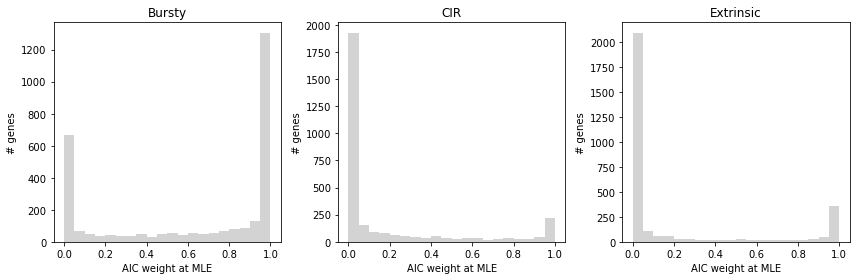

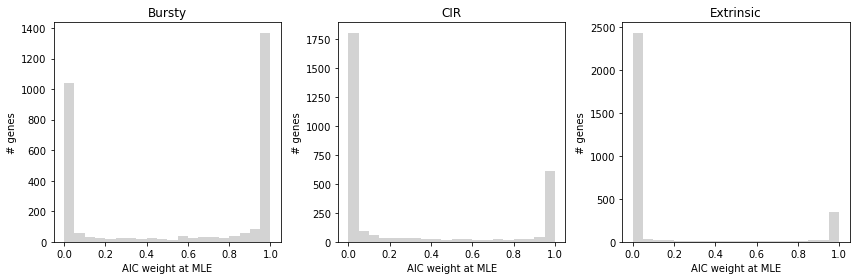

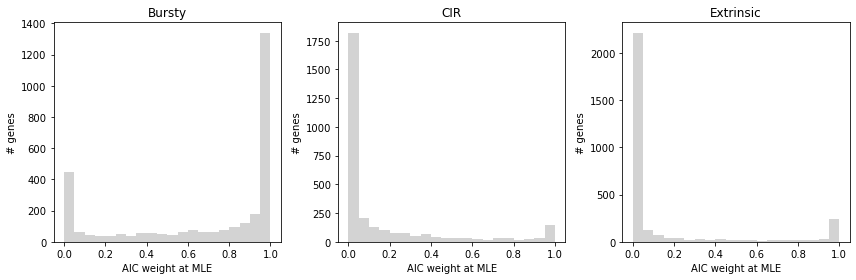

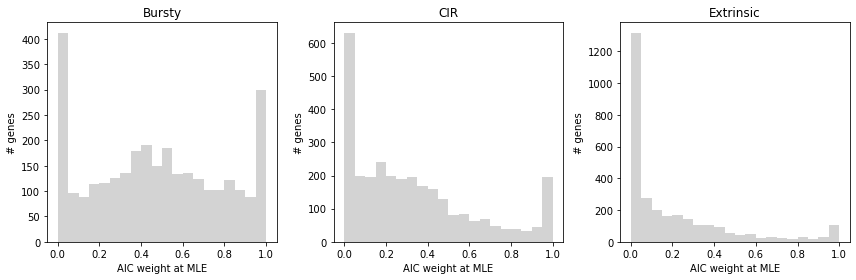

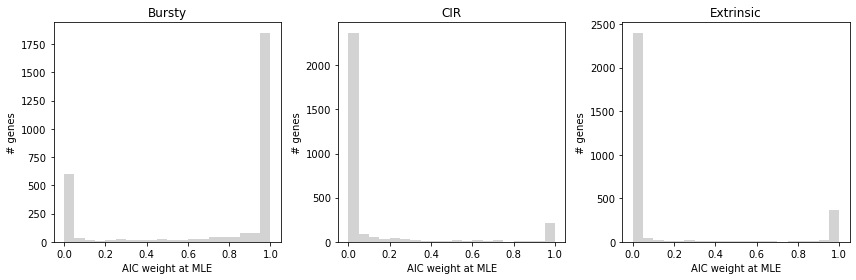

In [46]:
w = []
for j in range(n_datasets):
    print(j)
    w_ = plot_AIC_weights(sr_arr[j],sd_arr[j],models,meta=dataset_names[j],savefig=True)
    w.append(w_)

In [47]:
w = np.asarray(w)

In [48]:
# import plotly
# import plotly.express as px
# import pandas as pd

In [427]:
# thr = 0.8
gf_gou = (w[:,0,:]>0.9).all(0)
gf_cir = (w[:,1,:]>0.5).all(0)
gf_ext = (w[:,2,:]>0.8).all(0)

In [428]:
gf_gou.sum()

224

In [429]:
gf_cir.sum()

52

In [430]:
gf_ext.sum()

77

In [431]:
gn = sd_arr[0].gene_names

In [432]:
gf_cir.sum()+gf_gou.sum()+gf_ext.sum()

353

In [433]:
len(gn)

3000

In [434]:
gfs = [gf_gou,gf_cir,gf_ext]

In [435]:
chisq_thr = 5
gene_inds_kept = []
# for model_ind in range(1,2):
for model_ind in range(n_models):
    n_genes = gfs[model_ind].sum()
    gene_inds = np.where(gfs[model_ind])[0]
    keep = np.zeros((n_genes,n_datasets),dtype=bool)
    pval = np.zeros((n_genes,n_datasets))
    for gene_count,gene_ind in enumerate(gene_inds):
        for dataset in range(n_datasets):
            lm = [sd_arr[dataset].M[gene_ind], sd_arr[dataset].N[gene_ind]]
            pars = sr_arr[dataset][model_ind].phys_optimum[gene_ind]
            expect_freq = sr_arr[dataset][model_ind].model.eval_model_pss(pars,lm) * sd_arr[dataset].n_cells
            
            unique_values,counts = np.unique(np.vstack(\
                       (sd_arr[dataset].U[gene_ind],sd_arr[dataset].S[gene_ind])).astype(int),axis=1,\
                        return_counts=True) #create the dataset of observed counts
            expect_freq = expect_freq[unique_values[0],unique_values[1]]
                #the added bin accounts for all the stuff that's not in the 
                #observed categories
            expect_freq = np.concatenate((expect_freq,[sd_arr[dataset].n_cells-expect_freq.sum()]))
            counts = np.concatenate((counts,[0])) 
            
            filt = (expect_freq>chisq_thr) & (counts>chisq_thr)
            observed = np.concatenate((counts[filt],[counts[~filt].sum()]))
            proposed = np.concatenate((expect_freq[filt],[expect_freq[~filt].sum()])) #this is incredibly severe.
            csq = scipy.stats.mstats.chisquare(observed, proposed, 3) #3 dof because models have 3 parameters...
            pval[gene_count,dataset] = csq.pvalue
            if csq.pvalue>0.01:
                keep[gene_count,dataset] = True
                
    gene_inds_kept.append(gene_inds[keep.all(1)])


In [436]:
# pval[keep.all(1),:]

In [437]:
[len(x) for x in gene_inds_kept]

[33, 15, 21]

In [438]:
np.where(gn=='Pura')

(array([2487]),)

blue is GOU (model 0), red is CIR (model 1)

In [1183]:
ds=1

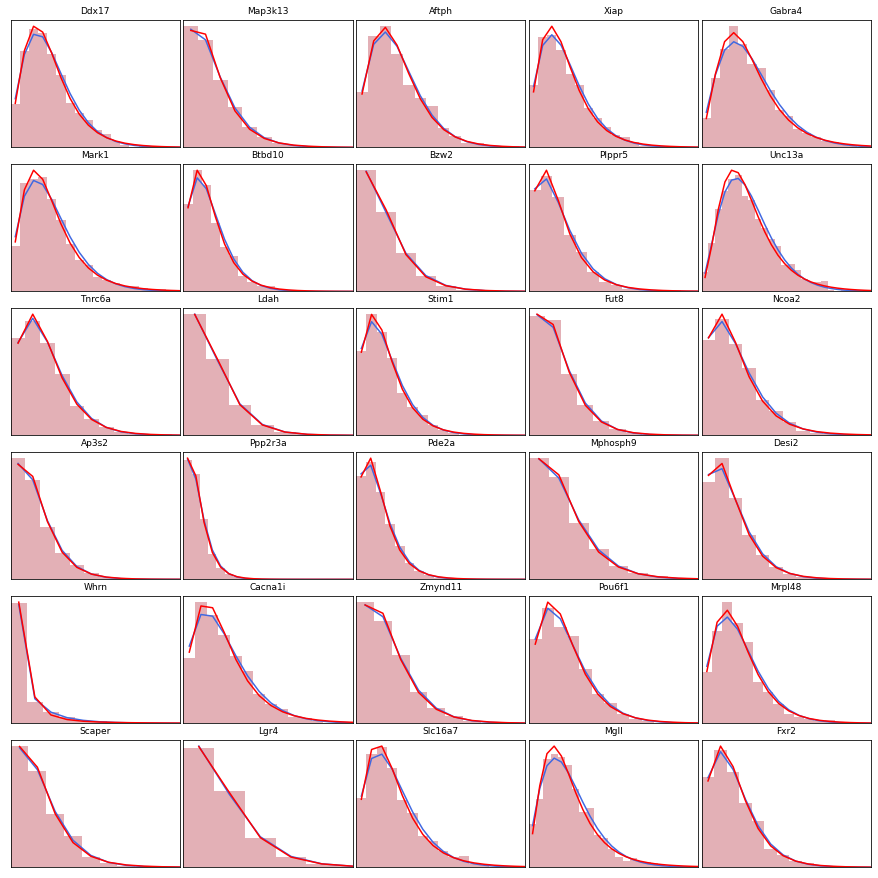

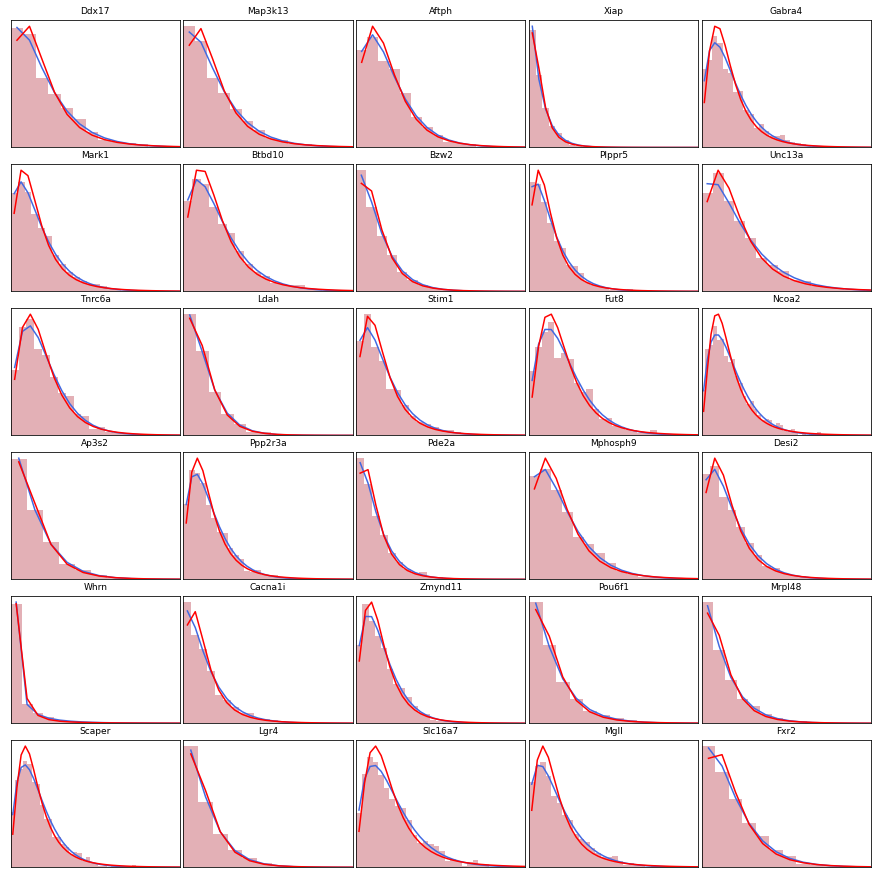

In [1184]:
compare_gene_distributions([sr_arr[ds][0],sr_arr[ds][1]],[sd_arr[ds],sd_arr[ds]],genes_to_plot=gene_inds_kept[0],\
                           sz=(6,5),figsize=(12,12),
                           marg='mature')
compare_gene_distributions([sr_arr[ds][0],sr_arr[ds][1]],[sd_arr[ds],sd_arr[ds]],genes_to_plot=gene_inds_kept[0],\
                           sz=(6,5),figsize=(12,12),
                           marg='nascent')

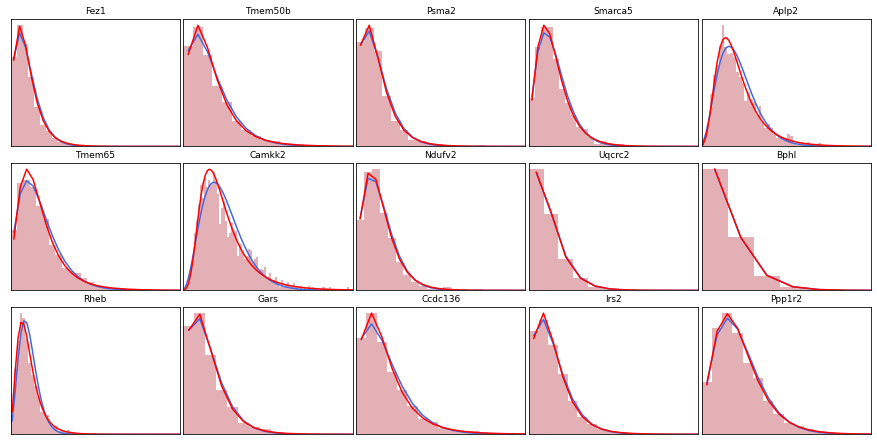

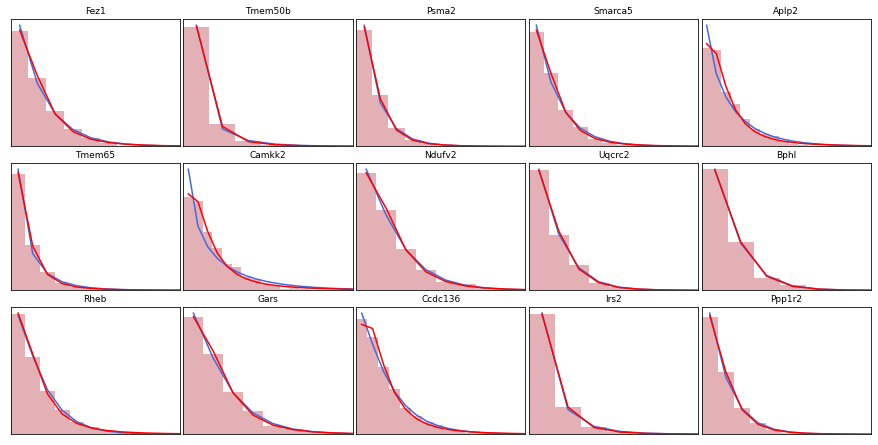

In [1185]:
compare_gene_distributions([sr_arr[ds][0],sr_arr[ds][1]],[sd_arr[ds],sd_arr[ds]],genes_to_plot=gene_inds_kept[1],\
                           sz=(3,5),figsize=(12,6),
                           marg='mature')
compare_gene_distributions([sr_arr[ds][0],sr_arr[ds][1]],[sd_arr[ds],sd_arr[ds]],genes_to_plot=gene_inds_kept[1],\
                           sz=(3,5),figsize=(12,6),
                           marg='nascent')

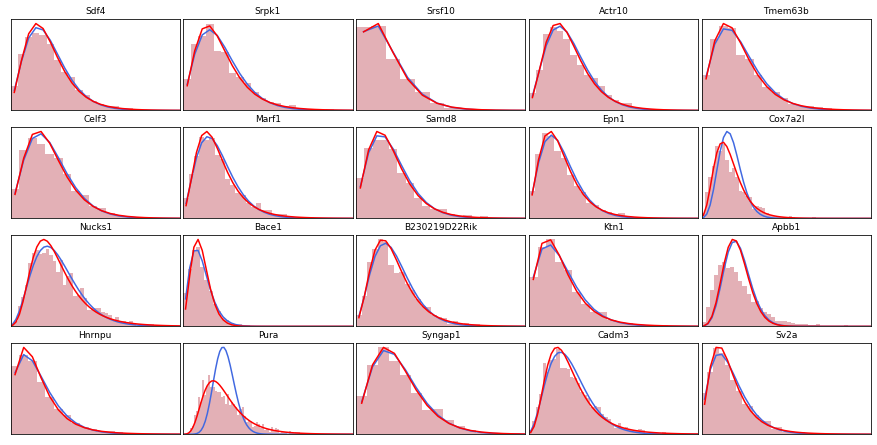

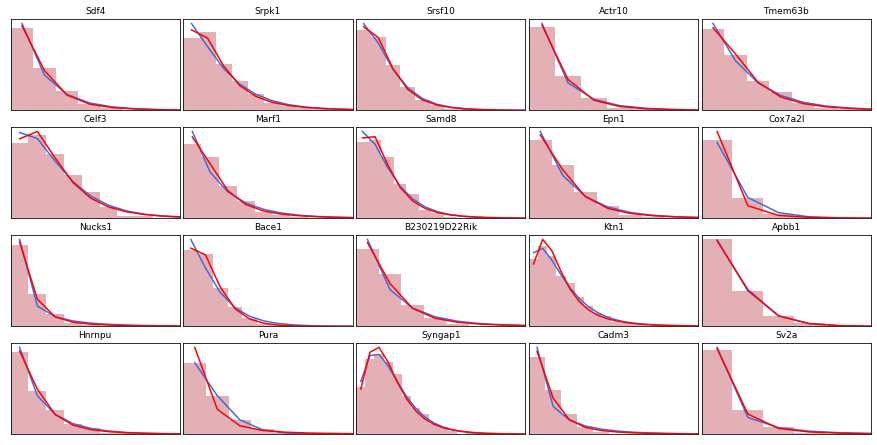

In [1186]:
compare_gene_distributions([sr_arr[ds][0],sr_arr[ds][1]],[sd_arr[ds],sd_arr[ds]],genes_to_plot=gene_inds_kept[2],\
                           sz=(4,5),figsize=(12,6),
                           marg='mature')
compare_gene_distributions([sr_arr[ds][0],sr_arr[ds][1]],[sd_arr[ds],sd_arr[ds]],genes_to_plot=gene_inds_kept[2],\
                           sz=(4,5),figsize=(12,6),
                           marg='nascent')

Also the "extrinsic" genes, but now red is extrinsic

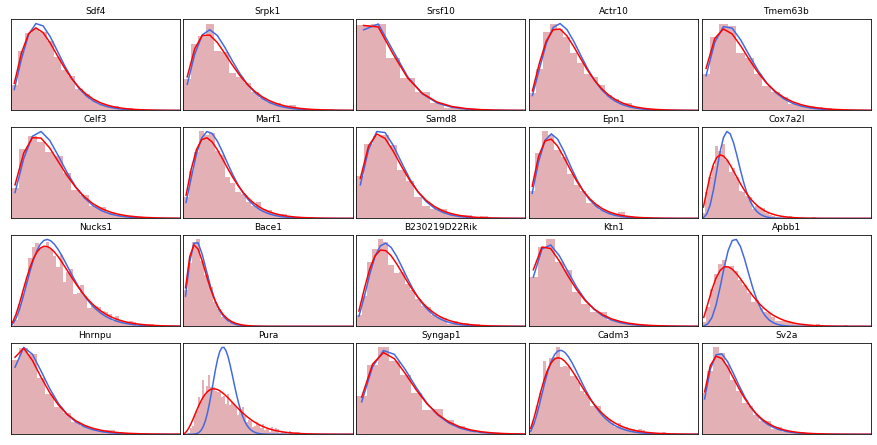

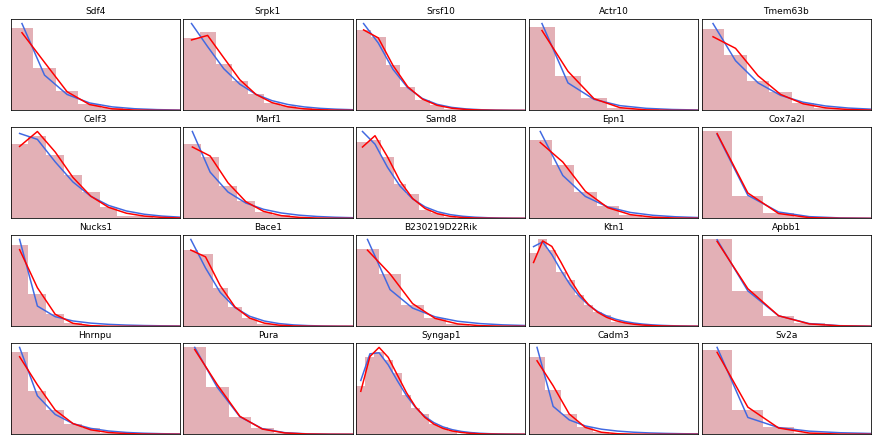

In [1187]:
compare_gene_distributions([sr_arr[ds][0],sr_arr[ds][2]],[sd_arr[ds],sd_arr[ds]],genes_to_plot=gene_inds_kept[2],\
                           sz=(4,5),figsize=(12,6),
                           marg='mature')
compare_gene_distributions([sr_arr[ds][0],sr_arr[ds][2]],[sd_arr[ds],sd_arr[ds]],genes_to_plot=gene_inds_kept[2],\
                           sz=(4,5),figsize=(12,6),
                           marg='nascent')

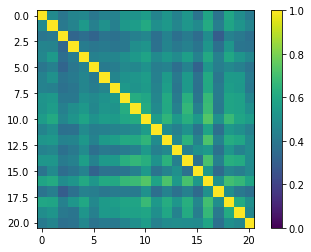

In [1188]:
plt.imshow(np.corrcoef(sd_arr[ds].S[gene_inds_kept[2]]),vmin=0,vmax=1)
plt.colorbar()

In [1189]:
# gn[gene_inds_kept[1]]

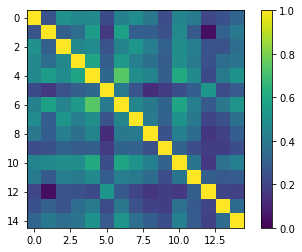

In [1190]:
plt.imshow(np.corrcoef(sd_arr[ds].S[gene_inds_kept[1]]),vmin=0,vmax=1)
plt.colorbar()

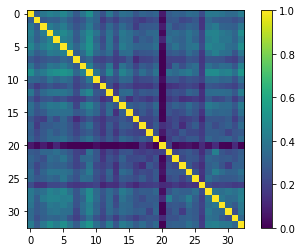

In [1191]:
plt.imshow(np.corrcoef(sd_arr[ds].S[gene_inds_kept[0]]),vmin=0,vmax=1)
plt.colorbar()

In [1193]:
n_cells = np.asarray([sd.n_cells for sd in sd_arr])
subtype_weights = n_cells/n_cells.sum()

In [1194]:
results = []
for model_ind in range(n_models):
    data = {'meta':models[model_ind],'genes':gn[gene_inds_kept[model_ind]],'aic':w[:,:,gene_inds_kept[model_ind]]}
    n_genes = len(data['genes'])
    pars = np.zeros((n_genes,n_datasets,3))
    for gene_count,gene_ind in enumerate(gene_inds_kept[model_ind]):
        for dataset in range(n_datasets):
            pars[gene_count,dataset] = sr_arr[dataset][model_ind].phys_optimum[gene_ind]
    data['pars'] = pars
    data['par_initial_guess'] = (pars*subtype_weights[None,:,None]).sum(1)
    results.append(data)


In [1195]:
# (pars*subtype_weights[None,:,None]).sum(1)

In [1196]:
with open('/home/ggorin/projects/GVFP_2021/fits/gg_220802_022_allen_celltypes_1/weights_and_genes.pickle','wb') as rfs:
    pickle.dump(results,rfs)

Start here for result analysis, with gene filtering done

In [291]:
with open('/home/ggorin/projects/GVFP_2021/fits/gg_220802_022_allen_celltypes_1/weights_and_genes.pickle','rb') as rfs:
    results = pickle.load(rfs)

In [293]:
# results[0]

In [5]:
# genes_kept = [x['genes'] for x in results]

Likelihood ratios

In [6]:
# gene_inds_kept[0]

In [7]:
dataset=0
# gene_ind = gene_inds_kept[0][0]
# unique_values,counts = np.unique(np.vstack(\
#                        (sd_arr[dataset].U[gene_ind],sd_arr[dataset].S[gene_ind])).astype(int),axis=1,\
#                         return_counts=True)

In [3]:
def par_fun_fullfit(fitinput):
    U,S,n_restarts,maxiter = fitinput
    reduced_guess=None
    limit=None
    pars_sde_gou = convert_pars(get_MLE('GOU',U,S,reduced_guess,disp=False,limit=limit,n_restarts=n_restarts,maxiter=maxiter))
    pars_sde_cir = convert_pars(get_MLE('CIR',U,S,reduced_guess,disp=False,limit=limit,n_restarts=n_restarts,maxiter=maxiter))
    lik_ratio, logL_gou, logL_cir = get_lik_ratio(pars_sde_gou,pars_sde_cir,U,S)
    return lik_ratio,pars_sde_gou,pars_sde_cir,logL_gou, logL_cir


In [4]:
def par_fun_fullfit_reducedguess(fitinput):
    U,S,reduced_guess,limit = fitinput
    pars_sde_gou = convert_pars(get_MLE('GOU',U,S,reduced_guess,disp=False,limit=limit,n_restarts=1,maxiter=10))
    pars_sde_cir = convert_pars(get_MLE('CIR',U,S,reduced_guess,disp=False,limit=limit,n_restarts=1,maxiter=10))
    lik_ratio, logL_gou, logL_cir = get_lik_ratio(pars_sde_gou,pars_sde_cir,U,S)
    return lik_ratio,pars_sde_gou,pars_sde_cir,logL_gou, logL_cir


In [1232]:
model_set = 0
try:
    gtr = gene_inds_kept[model_set][:5]
    n_genes_to_run = len(gtr)
    pool = multiprocessing.Pool(processes=5)
    fit_iterable = zip(sd_arr[dataset].U[gtr],\
                       sd_arr[dataset].S[gtr],
                       results[model_set]['par_initial_guess'][:n_genes_to_run],\
                       ['fast']*n_genes_to_run)
    gou_results = pool.map(par_fun_fullfit_reducedguess, fit_iterable)
    pool.close()
    pool.join()
except:
    print('failed')
    pool.terminate()
    pool.join()


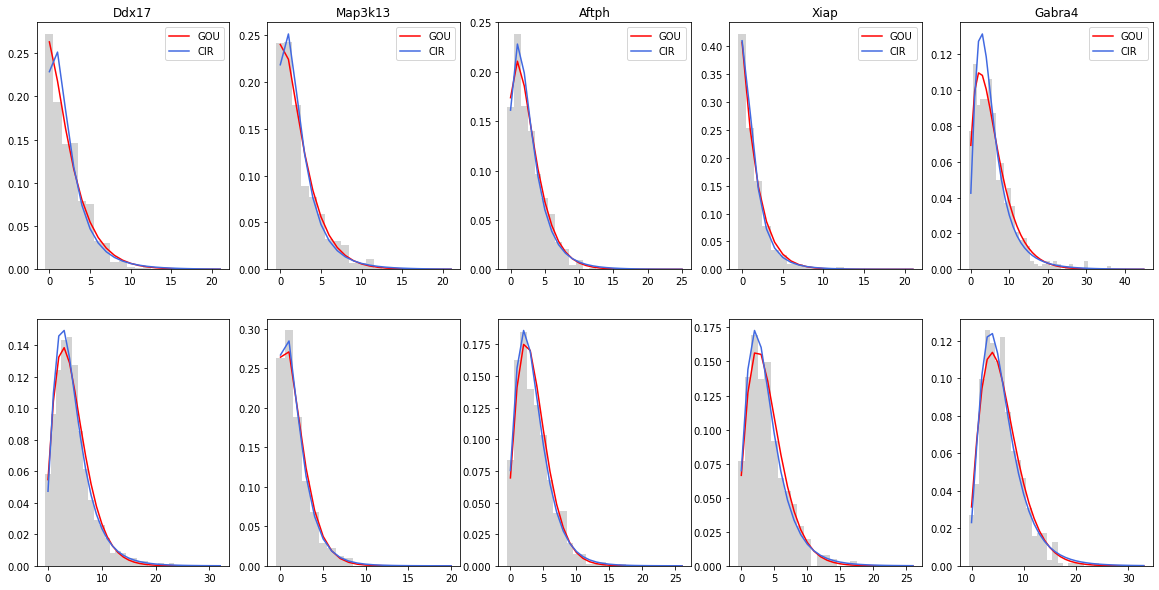

In [1233]:
fig1,ax1=plt.subplots(2,5,figsize=(20,10))

gou_reduced_color='lightcoral'
cir_reduced_color='skyblue'
gou_color='r'
cir_color='royalblue'

for k,gene_ind in enumerate(gene_inds_kept[model_set][:5]):
    mx = [sd_arr[dataset].M[gene_ind],sd_arr[dataset].N[gene_ind]]

    bins = np.arange(mx[0]-8)-0.5
    ax1[0,k].hist(sd_arr[dataset].U[gene_ind],bins,color='lightgray',density=True)
    ax1[0,k].set_title(gn[gene_ind])
    
    pars_sde_gou = gou_results[k][1]
    pars_sde_cir = gou_results[k][2]

    y = get_GOU_2sp([mx[0],1],pars_sde_gou)
    ax1[0,k].plot(y,'-',color=gou_color,label='GOU')
    y = get_CIR_2sp([mx[0],1],pars_sde_cir)
    ax1[0,k].plot(y,'-',color=cir_color,label='CIR')
    ax1[0,k].legend()

    bins = np.arange(mx[1]-8)-0.5
    ax1[1,k].hist(sd_arr[dataset].S[gene_ind],bins,color='lightgray',density=True)

    y = get_GOU_2sp([1,mx[1]],pars_sde_gou).squeeze()
    ax1[1,k].plot(y,'-',color=gou_color)
    y = get_CIR_2sp([1,mx[1]],pars_sde_cir).squeeze()
    ax1[1,k].plot(y,'-',color=cir_color)


In [1226]:
model_set = 1
try:
    gtr = gene_inds_kept[model_set][:5]
    n_genes_to_run = len(gtr)
    pool = multiprocessing.Pool(processes=5)
    fit_iterable = zip(sd_arr[dataset].U[gtr],\
                       sd_arr[dataset].S[gtr],
                       results[model_set]['par_initial_guess'][:n_genes_to_run],\
                       ['fast']*n_genes_to_run)
    cit_results = pool.map(par_fun_fullfit_reducedguess, fit_iterable)
    pool.close()
    pool.join()
except:
    print('failed')
    pool.terminate()
    pool.join()


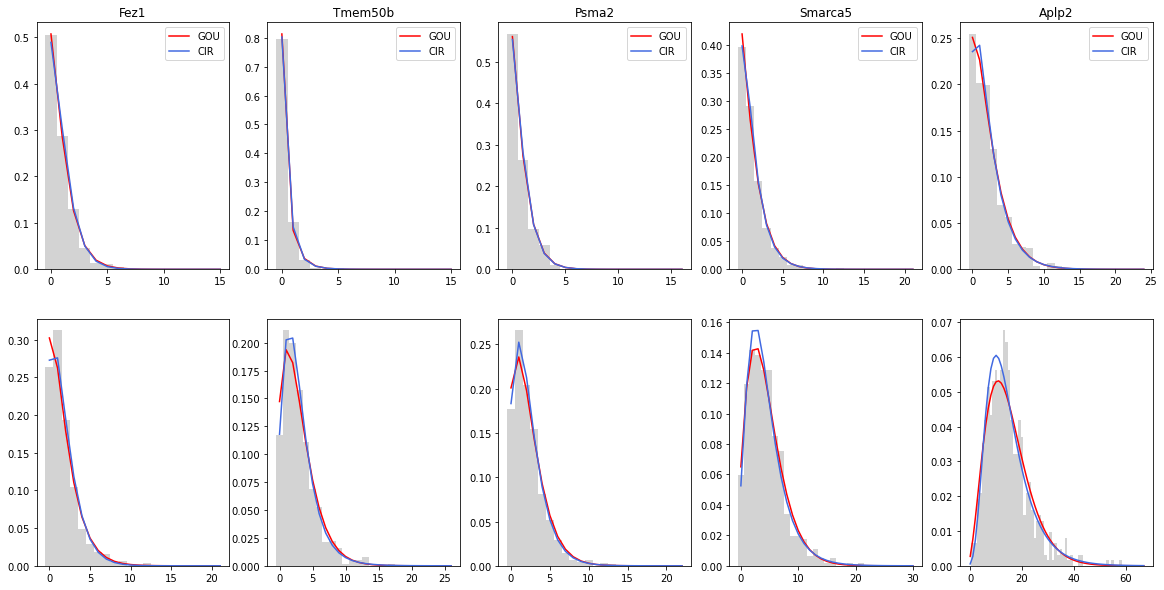

In [1227]:
fig1,ax1=plt.subplots(2,5,figsize=(20,10))

gou_reduced_color='lightcoral'
cir_reduced_color='skyblue'
gou_color='r'
cir_color='royalblue'

for k,gene_ind in enumerate(gene_inds_kept[model_set][:5]):
    mx = [sd_arr[dataset].M[gene_ind],sd_arr[dataset].N[gene_ind]]

    bins = np.arange(mx[0]-8)-0.5
    ax1[0,k].hist(sd_arr[dataset].U[gene_ind],bins,color='lightgray',density=True)
    ax1[0,k].set_title(gn[gene_ind])
    
    pars_sde_gou = cir_results[k][1]
    pars_sde_cir = cir_results[k][2]

    y = get_GOU_2sp([mx[0],1],pars_sde_gou)
    ax1[0,k].plot(y,'-',color=gou_color,label='GOU')
    y = get_CIR_2sp([mx[0],1],pars_sde_cir)
    ax1[0,k].plot(y,'-',color=cir_color,label='CIR')
    ax1[0,k].legend()

    bins = np.arange(mx[1]-8)-0.5
    ax1[1,k].hist(sd_arr[dataset].S[gene_ind],bins,color='lightgray',density=True)

    y = get_GOU_2sp([1,mx[1]],pars_sde_gou).squeeze()
    ax1[1,k].plot(y,'-',color=gou_color)
    y = get_CIR_2sp([1,mx[1]],pars_sde_cir).squeeze()
    ax1[1,k].plot(y,'-',color=cir_color)


In [1228]:
model_set = 2
try:
    gtr = gene_inds_kept[model_set][:5]
    n_genes_to_run = len(gtr)
    pool = multiprocessing.Pool(processes=5)
    fit_iterable = zip(sd_arr[dataset].U[gtr],\
                       sd_arr[dataset].S[gtr],
                       results[model_set]['par_initial_guess'][:n_genes_to_run],\
                       ['slow']*n_genes_to_run)
    ext_results = pool.map(par_fun_fullfit_reducedguess, fit_iterable)
    pool.close()
    pool.join()
except:
    print('failed')
    pool.terminate()
    pool.join()


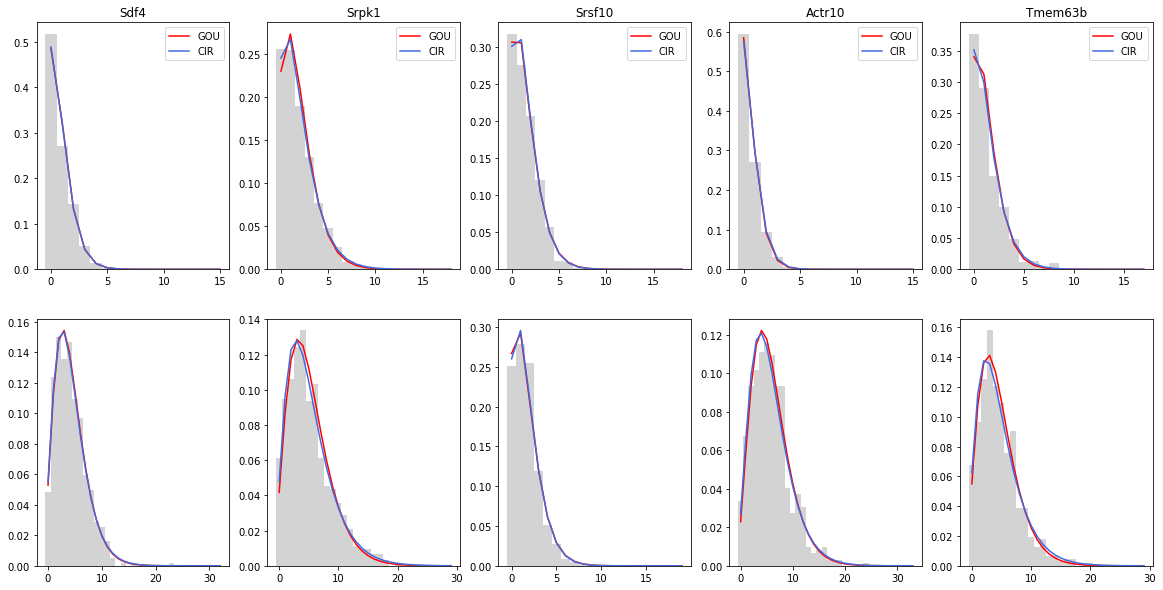

In [1229]:
fig1,ax1=plt.subplots(2,5,figsize=(20,10))

gou_reduced_color='lightcoral'
cir_reduced_color='skyblue'
gou_color='r'
cir_color='royalblue'

for k,gene_ind in enumerate(gene_inds_kept[model_set][:5]):
    mx = [sd_arr[dataset].M[gene_ind],sd_arr[dataset].N[gene_ind]]

    bins = np.arange(mx[0]-8)-0.5
    ax1[0,k].hist(sd_arr[dataset].U[gene_ind],bins,color='lightgray',density=True)
    ax1[0,k].set_title(gn[gene_ind])
    
    pars_sde_gou = ext_results[k][1]
    pars_sde_cir = ext_results[k][2]

    y = get_GOU_2sp([mx[0],1],pars_sde_gou)
    ax1[0,k].plot(y,'-',color=gou_color,label='GOU')
    y = get_CIR_2sp([mx[0],1],pars_sde_cir)
    ax1[0,k].plot(y,'-',color=cir_color,label='CIR')
    ax1[0,k].legend()

    bins = np.arange(mx[1]-8)-0.5
    ax1[1,k].hist(sd_arr[dataset].S[gene_ind],bins,color='lightgray',density=True)

    y = get_GOU_2sp([1,mx[1]],pars_sde_gou).squeeze()
    ax1[1,k].plot(y,'-',color=gou_color)
    y = get_CIR_2sp([1,mx[1]],pars_sde_cir).squeeze()
    ax1[1,k].plot(y,'-',color=cir_color)


In [1234]:
lik_ratios = [x[0] for x in gou_results] + [x[0] for x in cir_results] + [x[0] for x in ext_results] 

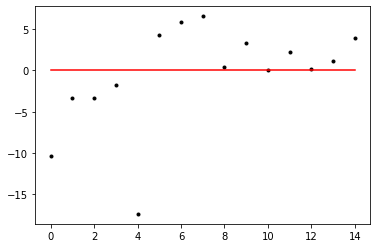

In [1235]:
plt.plot(lik_ratios,'k.')
plt.plot([0,14],[0,0],'r-')
# plt.ylim([-20,20])

In [1237]:
lik_ratios

[-10.333586159193601,
 -3.340418360789954,
 -3.2965846146857984,
 -1.7345921491064473,
 -17.364389034519263,
 4.2673145941769235,
 5.803844536329279,
 6.539855423605559,
 0.36582753122957,
 3.3117794461791163,
 0.028145549941200443,
 2.213501835832176,
 0.14542298387959818,
 1.1630213392750193,
 3.9466895999048575]

# Out-of-sample analysis (large)

In [119]:
n_cores=33

In [120]:
with open('/home/ggorin/projects/GVFP_2021/fits/gg_220802_022_allen_celltypes_1/weights_and_genes.pickle','rb') as rfs:
    results = pickle.load(rfs)

In [121]:
genes_kept = [x['genes'] for x in results]
sample_names = ['C01','B08','H12','F08']
models=('Bursty','CIR','Extrinsic')
dataset_names = ['allen_'+y+'_glu'  for y in sample_names] 
sample_looms = ['/home/ggorin/count_data/loom_allen_celltype_kb/test/'+x+'.loom' for x in dataset_names] 
gene_names_to_run = [x for x in genes_kept]
# gene_names_to_run = [x[:5] for x in genes_kept]


In [ ]:
# %load_ext line_profiler

In [122]:
[len(x) for x in genes_kept]

[33, 15, 21]

In [123]:
# fitit=list(zip(U[gene_locations],\
#                                S[gene_locations],\
#                                [1]*n_genes_to_run,\
#                                [5]*n_genes_to_run))[0]
# # par_fun_fullfit(fitit)

In [124]:
# %lprun -f par_fun_fullfit par_fun_fullfit(fitit)

In [125]:
import multiprocessing
# pool=multiprocessing.Pool(processes=n_cores)

t1=time.time()
# test_data_ind = 2
oss_res = {}
# genes_to_run = [gene_inds_kept[0][:5], gene_inds_kept[1][:6], gene_inds_kept[0][:4]]
# [x[:5] for x in gene_inds_kept]

for test_data_ind in range(len(sample_looms)):
    print(sample_names[test_data_ind])
    with lp.connect(sample_looms[test_data_ind]) as ds:
        U = ds.layers['unspliced'][:]
        S = ds.layers['spliced'][:]
        loom_gene_names = ds.ra['gene_name']
    oos_res_dataset = {}
    for model_set in range(3):
        print(models[model_set])
        try:
#             gntr = gene_names_to_run[model_set]
#             gene_locations = [np.where(loom_gene_names==x)[0][0] for x in gntr]
            n_genes_to_run = len(gntr)
            pool = multiprocessing.Pool(processes=n_cores)
            fit_iterable = zip(U[gene_locations],\
                               S[gene_locations],\
                               [1]*n_genes_to_run,\
                               [5]*n_genes_to_run)
            model_res = pool.map(par_fun_fullfit, fit_iterable)
            oos_res_dataset[models[model_set]] = model_res
            pool.close()
            pool.join()
        except:
            print('failed')
            pool.terminate()
            pool.join()
    oss_res[sample_names[test_data_ind]] = oos_res_dataset
t2 = time.time()
print('Runtime: {:.1f} minutes.'.format((t2-t1)/60))

C01
Bursty
CIR
Extrinsic
B08
Bursty
CIR
Extrinsic
H12
Bursty
CIR
Extrinsic
F08
Bursty
CIR
Extrinsic
Runtime: 27.7 minutes.


In [39]:
# len(np.concatenate(indices))

In [ ]:
# genes_kept

In [126]:
lik_ratios_oos = [[[z[0] for z in oss_res[x][y]] for y in models] for x in sample_names]

In [127]:
indices = [np.arange(0,len(gene_names_to_run[0])), \
           np.arange(len(gene_names_to_run[0]), len(gene_names_to_run[0]) + len(gene_names_to_run[1])),\
           np.arange(len(gene_names_to_run[0]) + len(gene_names_to_run[1]), \
                                                len(gene_names_to_run[0]) + len(gene_names_to_run[1]) + len(gene_names_to_run[2]))]

In [128]:
# genes_ran = [gn[x] for x in genes_to_run]

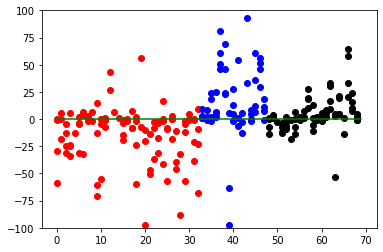

In [129]:
colors= ('r','b','k')
for test_data_ind in range(len(sample_names)):
    for model_set in range(3):
        plt.scatter(indices[model_set],lik_ratios_oos[test_data_ind][model_set],c=colors[model_set])
plt.ylim([-100,100])
plt.plot([0,sum([len(x) for x in indices])],[0,0],'g-')

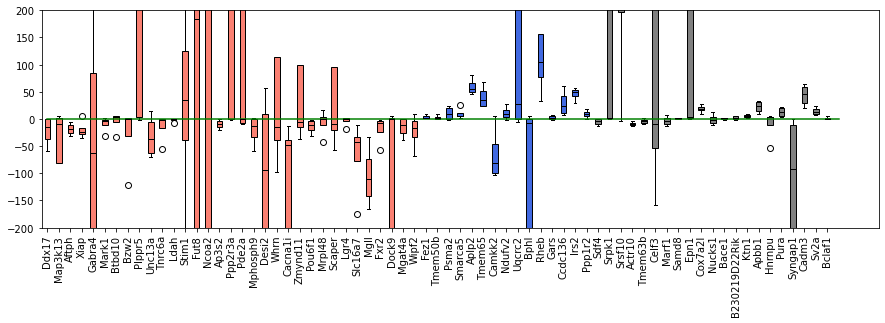

In [131]:
colors= ('salmon','royalblue','grey')
fig1,ax1 = plt.subplots(1,1,figsize=(15,4))
for model_set in range(3):
    d = np.asarray([lik_ratios_oos[test_data_ind][model_set] for test_data_ind in range(len(sample_looms))])
    bplot = ax1.boxplot(d,positions=indices[model_set],vert=True,patch_artist=True)
    for patch in bplot['boxes']:
        patch.set_facecolor(colors[model_set])
    for median in bplot['medians']:
        median.set_color('k')
#     print(bplot)
#     for test_data_ind in range(len(sample_looms)):
#         plt.scatter(indices[model_set],lik_ratios_oos[test_data_ind][model_set],c=colors[model_set])
ax1.set_ylim([-200,200])
ax1.plot([0,sum([len(x) for x in indices])],[0,0],'g-')
_=ax1.set_xticks(np.concatenate(indices),np.concatenate(gene_names_to_run),rotation=90)

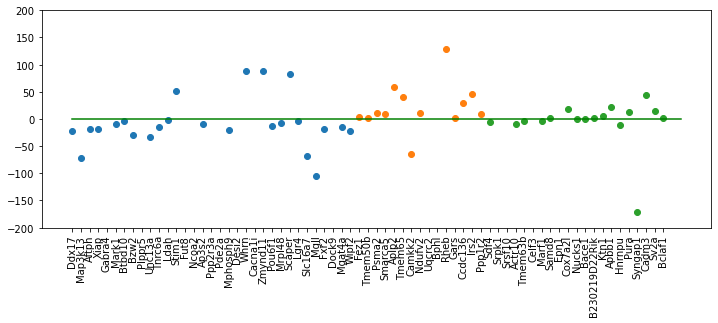

In [136]:
colors= ('salmon','royalblue','grey')
fig1,ax1 = plt.subplots(1,1,figsize=(12,4))
for model_set in range(3):
    d = np.asarray([lik_ratios_oos[test_data_ind][model_set] for test_data_ind in range(len(sample_looms))])
    bplot = ax1.scatter(indices[model_set],d.mean(0))
ax1.set_ylim([-200,200])
ax1.plot([0,1+sum([len(x) for x in indices])],[0,0],'g-')
_=ax1.set_xticks(np.concatenate(indices),np.concatenate(gene_names_to_run),rotation=90)

In [133]:
# genes_ran = [gn[x] for x in genes_to_run]

In [134]:
with open('/home/ggorin/projects/GVFP_2021/fits/gg_220802_022_allen_celltypes_1/logl_fit_results_multis_full_220806.pickle','wb') as rfs:
    pickle.dump((oss_res,lik_ratios_oos,sample_names,models,gene_names_to_run),rfs)

In [135]:
# with open('/home/ggorin/projects/GVFP_2021/fits/gg_220802_022_allen_celltypes_1/logl_fit_results_multis_full.pickle','rb') as rfs:
#     oss_res,lik_ratios_oos,sample_names,models,gene_names_to_run=pickle.load(rfs)

# Goodness of fit

In [186]:
gou_pars  = np.array([[np.asarray([z[1] for z in oss_res[x][y]]) for y in models] for x in sample_names],dtype=object)
cir_pars  = np.array([[np.asarray([z[2] for z in oss_res[x][y]]) for y in models] for x in sample_names],dtype=object)

# ACCEPTED_ = 

In [197]:
gou_pars[1][0].shape

(33, 5)

In [224]:
# import copy
# lik_ratios_checked = np.array(copy.copy([[[z[0] for z in oss_res[x][y]] for y in models] for x in sample_names]),dtype=object)

In [225]:
# lik_ratios_checked.shape

(4, 3)

In [279]:
import copy
lik_ratios_checked = np.array(copy.copy([[[z[0] for z in oss_res[x][y]] for y in models] for x in sample_names]),dtype=object)
chisq_thr=5
for test_data_ind in range(len(sample_looms)):
# for test_data_ind in range(1):
    print(sample_names[test_data_ind])
    with lp.connect(sample_looms[test_data_ind]) as ds:
        U = ds.layers['unspliced'][:]
        S = ds.layers['spliced'][:]
        loom_gene_names = ds.ra['gene_name']
    n_cells = S.shape[1]
    for model_set in range(3):
        print(models[model_set])
        gntr = gene_names_to_run[model_set]
        gene_locations = [np.where(loom_gene_names==x)[0][0] for x in gntr]
#         print(loom_gene_names[gene_locations])
        for gene_count,gene_ind in enumerate(gene_locations):
            lm = np.asarray([U[gene_ind].max()+10,S[gene_ind].max()+10],dtype=int) 
            
            pval = []
            for which_model in ('gou','cir'):
                if which_model == 'gou':
                    par_array = gou_pars
                    lik_fun = get_GOU_2sp
                elif which_model == 'cir':
                    par_array = cir_pars
                    lik_fun = get_CIR_2sp
                    
                pars_gene = par_array[test_data_ind,model_set][gene_count]
                expect_freq = lik_fun(lm,pars_gene) * n_cells

                unique_values,counts = np.unique(np.vstack((U[gene_ind],S[gene_ind])).astype(int),axis=1,return_counts=True) 

                expect_freq = expect_freq[unique_values[0],unique_values[1]]

                expect_freq = np.concatenate((expect_freq,[n_cells-expect_freq.sum()]))
                counts = np.concatenate((counts,[0]))

                filt = (expect_freq>chisq_thr) & (counts>chisq_thr)

                observed = np.concatenate((counts[filt],[counts[~filt].sum()]))
                proposed = np.concatenate((expect_freq[filt],[expect_freq[~filt].sum()])) #this is incredibly severe.
                csq = scipy.stats.mstats.chisquare(observed, proposed, 4)
                pval.append(csq.pvalue)
            if (np.asarray(pval)<1e-6).any():
                lik_ratios_checked[test_data_ind,model_set][gene_count] = np.nan

C01
Bursty
['Ddx17' 'Map3k13' 'Aftph' 'Xiap' 'Gabra4' 'Mark1' 'Btbd10' 'Bzw2'
 'Plppr5' 'Unc13a' 'Tnrc6a' 'Ldah' 'Stim1' 'Fut8' 'Ncoa2' 'Ap3s2'
 'Ppp2r3a' 'Pde2a' 'Mphosph9' 'Desi2' 'Whrn' 'Cacna1i' 'Zmynd11' 'Pou6f1'
 'Mrpl48' 'Scaper' 'Lgr4' 'Slc16a7' 'Mgll' 'Fxr2' 'Dock9' 'Mgat4a' 'Wipf2']
CIR
['Fez1' 'Tmem50b' 'Psma2' 'Smarca5' 'Aplp2' 'Tmem65' 'Camkk2' 'Ndufv2'
 'Uqcrc2' 'Bphl' 'Rheb' 'Gars' 'Ccdc136' 'Irs2' 'Ppp1r2']
Extrinsic
['Sdf4' 'Srpk1' 'Srsf10' 'Actr10' 'Tmem63b' 'Celf3' 'Marf1' 'Samd8' 'Epn1'
 'Cox7a2l' 'Nucks1' 'Bace1' 'B230219D22Rik' 'Ktn1' 'Apbb1' 'Hnrnpu' 'Pura'
 'Syngap1' 'Cadm3' 'Sv2a' 'Bclaf1']
B08
Bursty
['Ddx17' 'Map3k13' 'Aftph' 'Xiap' 'Gabra4' 'Mark1' 'Btbd10' 'Bzw2'
 'Plppr5' 'Unc13a' 'Tnrc6a' 'Ldah' 'Stim1' 'Fut8' 'Ncoa2' 'Ap3s2'
 'Ppp2r3a' 'Pde2a' 'Mphosph9' 'Desi2' 'Whrn' 'Cacna1i' 'Zmynd11' 'Pou6f1'
 'Mrpl48' 'Scaper' 'Lgr4' 'Slc16a7' 'Mgll' 'Fxr2' 'Dock9' 'Mgat4a' 'Wipf2']
CIR
['Fez1' 'Tmem50b' 'Psma2' 'Smarca5' 'Aplp2' 'Tmem65' 'Camkk2' 'Ndufv2'
 'Uqcrc2

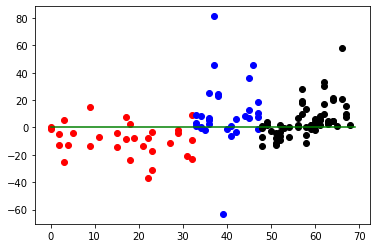

In [283]:
colors= ('r','b','k')
for test_data_ind in range(len(sample_names)):
    for model_set in range(3):
        plt.scatter(indices[model_set],lik_ratios_checked[test_data_ind][model_set],c=colors[model_set])
# plt.ylim([-100,100])
plt.plot([0,sum([len(x) for x in indices])],[0,0],'g-')

/tmp/ipykernel_2675487/1852441025.py:5: RuntimeWarning: Mean of empty slice
  bplot = ax1.scatter(indices[model_set],np.nanmean(d,0))


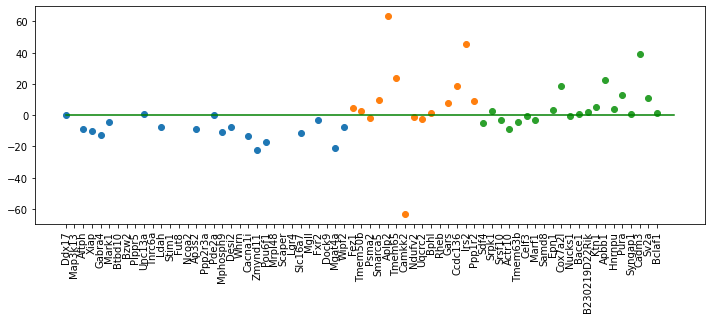

In [289]:
colors= ('salmon','royalblue','grey')
fig1,ax1 = plt.subplots(1,1,figsize=(12,4))
for model_set in range(3):
    d = np.asarray([lik_ratios_checked[test_data_ind][model_set] for test_data_ind in range(len(sample_looms))])
    bplot = ax1.scatter(indices[model_set],np.nanmean(d,0))
# ax1.set_ylim([-200,200])
ax1.plot([0,1+sum([len(x) for x in indices])],[0,0],'g-')
_=ax1.set_xticks(np.concatenate(indices),np.concatenate(gene_names_to_run),rotation=90)

In [264]:
proposed

array([ 63.84824166, 175.48868728, 242.72160989, 225.25498565,
       157.80048444,  89.01182381,  42.11434379,  17.190897  ,
         6.18040235,  96.01109676, 265.53783692, 369.57228213,
       345.1340848 , 243.30613602, 138.11233942,  65.76027123,
        27.0140409 ,   9.77403429,  73.38432434, 204.22959144,
       286.02946857, 268.79865182, 190.69039749, 108.93148259,
        52.19612967,  21.57876522,   7.85745203,  38.02103196,
       106.47666635, 150.06187262, 141.91198362, 101.31220568,
        58.24194148,  28.08527566,  11.68512526,  15.02542817,
        42.34250352,  60.0509785 ,  57.14851003,  41.05746802,
        23.75303905,  11.52718668,  13.70263855,  19.55592445,
        18.72846213,  13.54055985,   7.88350158,   5.39962542,
         5.20389162,  55.75431827])

In [265]:
lik_ratios_checked[0][2]

[0.7080109037069633,
 nan,
 nan,
 -7.630135356890605,
 -3.0006746390354238,
 nan,
 nan,
 nan,
 nan,
 9.89940341594047,
 0.6080414156858751,
 1.815771794934335,
 nan,
 1.547015667470987,
 9.672271643508793,
 4.872513738033376,
 4.5138225475966465,
 nan,
 nan,
 nan,
 nan]

In [166]:
# chisq_thr = 5
# gene_inds_kept = []
# for model_ind in range(1,2):
# for model_ind in range(n_models):
#     n_genes = gfs[model_ind].sum()
#     gene_inds = np.where(gfs[model_ind])[0]
#     keep = np.zeros((n_genes,n_datasets),dtype=bool)
#     pval = np.zeros((n_genes,n_datasets))
#     for gene_count,gene_ind in enumerate(gene_inds):
#         for dataset in range(n_datasets):
#             lm = [sd_arr[dataset].M[gene_ind], sd_arr[dataset].N[gene_ind]]
#             pars = sr_arr[dataset][model_ind].phys_optimum[gene_ind]
#             expect_freq = sr_arr[dataset][model_ind].model.eval_model_pss(pars,lm) * sd_arr[dataset].n_cells
            
#             unique_values,counts = np.unique(np.vstack(\
#                        (sd_arr[dataset].U[gene_ind],sd_arr[dataset].S[gene_ind])).astype(int),axis=1,\
#                         return_counts=True) #create the dataset of observed counts
#             expect_freq = expect_freq[unique_values[0],unique_values[1]]
#                 #the added bin accounts for all the stuff that's not in the 
#                 #observed categories
#             expect_freq = np.concatenate((expect_freq,[sd_arr[dataset].n_cells-expect_freq.sum()]))
#             counts = np.concatenate((counts,[0])) 
            
#             filt = (expect_freq>chisq_thr) & (counts>chisq_thr)
#             observed = np.concatenate((counts[filt],[counts[~filt].sum()]))
#             proposed = np.concatenate((expect_freq[filt],[expect_freq[~filt].sum()])) #this is incredibly severe.
#             csq = scipy.stats.mstats.chisquare(observed, proposed, 3) #3 dof because models have 3 parameters...
#             pval[gene_count,dataset] = csq.pvalue
#             if csq.pvalue>0.01:
#                 keep[gene_count,dataset] = True
                
#     gene_inds_kept.append(gene_inds[keep.all(1)])


In [ ]:
chisq_thr = 5
gene_inds_kept = []
# for model_ind in range(1,2):
for model_ind in range(n_models):
    n_genes = gfs[model_ind].sum()
    gene_inds = np.where(gfs[model_ind])[0]
    keep = np.zeros((n_genes,n_datasets),dtype=bool)
    pval = np.zeros((n_genes,n_datasets))
    for gene_count,gene_ind in enumerate(gene_inds):
        for dataset in range(n_datasets):
            lm = [sd_arr[dataset].M[gene_ind], sd_arr[dataset].N[gene_ind]]
            pars = sr_arr[dataset][model_ind].phys_optimum[gene_ind]
            expect_freq = sr_arr[dataset][model_ind].model.eval_model_pss(pars,lm) * sd_arr[dataset].n_cells
            
            unique_values,counts = np.unique(np.vstack(\
                       (sd_arr[dataset].U[gene_ind],sd_arr[dataset].S[gene_ind])).astype(int),axis=1,\
                        return_counts=True) #create the dataset of observed counts
            expect_freq = expect_freq[unique_values[0],unique_values[1]]
                #the added bin accounts for all the stuff that's not in the 
                #observed categories
            expect_freq = np.concatenate((expect_freq,[sd_arr[dataset].n_cells-expect_freq.sum()]))
            counts = np.concatenate((counts,[0])) 
            
            filt = (expect_freq>chisq_thr) & (counts>chisq_thr)
            observed = np.concatenate((counts[filt],[counts[~filt].sum()]))
            proposed = np.concatenate((expect_freq[filt],[expect_freq[~filt].sum()])) #this is incredibly severe.
            csq = scipy.stats.mstats.chisquare(observed, proposed, 3) #3 dof because models have 3 parameters...
            pval[gene_count,dataset] = csq.pvalue
            if csq.pvalue>0.01:
                keep[gene_count,dataset] = True
                
    gene_inds_kept.append(gene_inds[keep.all(1)])


# Comparison to real data

In [92]:
# oss_res[sample_names[0]][models[2]]

In [154]:

test_data_ind = 0
# gtr = gene_names_to_run[model_set]
# gene_locations = [np.where(loom_gene_names==x)[0][0] for x in gn[gtr]]

with lp.connect(sample_looms[test_data_ind]) as ds:
    U = ds.layers['unspliced'][:]
    S = ds.layers['spliced'][:]
    loom_gene_names = ds.ra['gene_name']

In [158]:
gntr

array(['Ddx17', 'Map3k13', 'Aftph', 'Xiap', 'Gabra4', 'Mark1', 'Btbd10',
       'Bzw2', 'Plppr5', 'Unc13a', 'Tnrc6a', 'Ldah', 'Stim1', 'Fut8',
       'Ncoa2', 'Ap3s2', 'Ppp2r3a', 'Pde2a', 'Mphosph9', 'Desi2', 'Whrn',
       'Cacna1i', 'Zmynd11', 'Pou6f1', 'Mrpl48', 'Scaper', 'Lgr4',
       'Slc16a7', 'Mgll', 'Fxr2', 'Dock9', 'Mgat4a', 'Wipf2'],
      dtype='<U16')

21


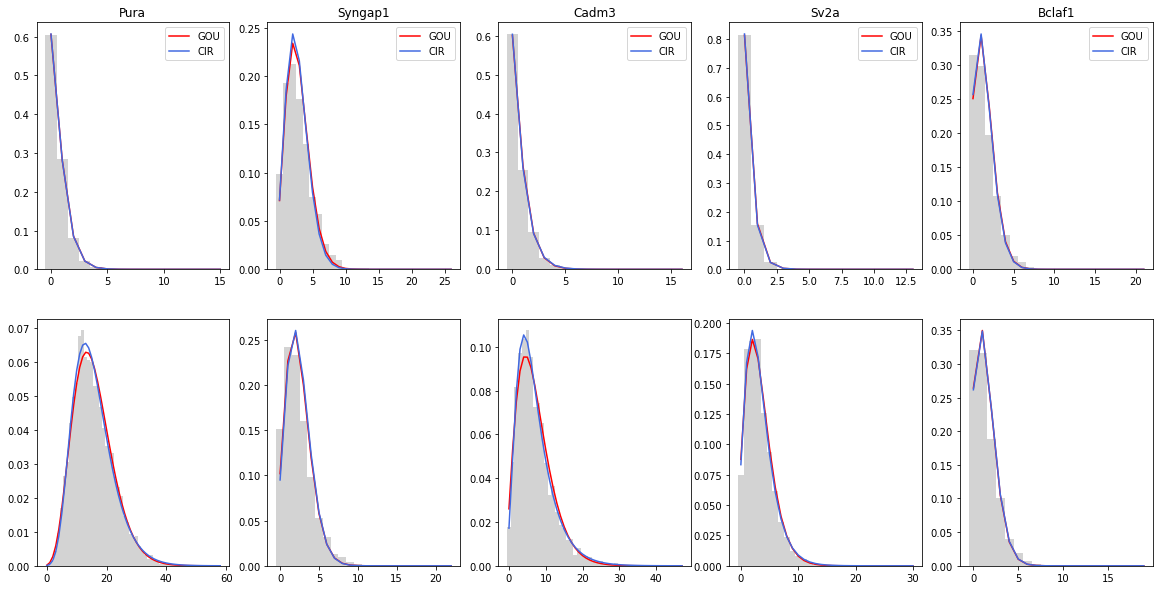

In [250]:
fig1,ax1=plt.subplots(2,5,figsize=(20,10))

gou_reduced_color='lightcoral'
cir_reduced_color='skyblue'
gou_color='r'
cir_color='royalblue'

model_set=2
gntr = gene_names_to_run[model_set]
gene_locations = np.asarray([np.where(loom_gene_names==x)[0][0] for x in gntr])
print(len(gene_locations))
# genes_to_plot = np.arange(10,15)
genes_to_plot=np.arange(16,21)

for k,gene_ind in enumerate(gene_locations[genes_to_plot]):
    mx = np.asarray([U[gene_ind].max()+10,S[gene_ind].max()+10],dtype=int)

    bins = np.arange(mx[0]-8)-0.5
    ax1[0,k].hist(U[gene_ind],bins,color='lightgray',density=True)
    ax1[0,k].set_title(loom_gene_names[gene_ind])
    
    pars_sde_gou = oss_res[sample_names[test_data_ind]][models[model_set]][k+genes_to_plot[0]][1]
    pars_sde_cir = oss_res[sample_names[test_data_ind]][models[model_set]][k+genes_to_plot[0]][2]

    y = get_GOU_2sp([mx[0],1],pars_sde_gou)
    ax1[0,k].plot(y,'-',color=gou_color,label='GOU')
    y = get_CIR_2sp([mx[0],1],pars_sde_cir)
    ax1[0,k].plot(y,'-',color=cir_color,label='CIR')
    ax1[0,k].legend()

    bins = np.arange(mx[1]-8)-0.5
    ax1[1,k].hist(S[gene_ind],bins,color='lightgray',density=True)

    y = get_GOU_2sp([1,mx[1]],pars_sde_gou).squeeze()
    ax1[1,k].plot(y,'-',color=gou_color)
    y = get_CIR_2sp([1,mx[1]],pars_sde_cir).squeeze()
    ax1[1,k].plot(y,'-',color=cir_color)


# Out-of-sample data analysis

In [923]:
# n_restarts = 4

In [1092]:
cell_type_names = ['C01','B08','H12','F08']
dataset_names = ['allen_'+y+'_glu'  for y in cell_type_names] 
cell_type_looms = ['/home/ggorin/count_data/loom_allen_celltype_kb/test/'+x+'.loom' for x in dataset_names] 
test_data_ind = 2
with lp.connect(cell_type_looms[test_data_ind]) as ds:
    U = ds.layers['unspliced'][:]
    S = ds.layers['spliced'][:]
    loom_gene_names = ds.ra['gene_name']

    genes_to_run = [x[:5] for x in gene_inds_kept]
    
    model_set = 0
    try:
        gtr = genes_to_run[model_set]
        gene_locations = [np.where(loom_gene_names==x)[0][0] for x in gn[gtr]]
        n_genes_to_run = len(gtr)
        pool = multiprocessing.Pool(processes=n_cores)
        fit_iterable = zip(U[gene_locations],\
                           S[gene_locations],\
                           [1]*n_genes_to_run,\
                           [10]*n_genes_to_run)
        gou_results_test = pool.map(par_fun_fullfit, fit_iterable)
        pool.close()
        pool.join()
    except:
        print('failed')
        pool.terminate()
        pool.join()

#     genes_to_run = [x for x in gene_inds_kept]

(array([  9.,  15.,  43.,  75., 101., 147., 165., 190., 212., 223., 248.,
        246., 266., 239., 215., 207., 177., 158., 140.,  83.,  72.,  36.,
         26.,  17.,  14.,   6.,   2.,   0.,   2.,   1.]),
 array([4.217984 , 4.24972  , 4.2814565, 4.3131924, 4.3449283, 4.376664 ,
        4.4084005, 4.4401364, 4.4718723, 4.5036087, 4.5353446, 4.5670805,
        4.598817 , 4.630553 , 4.6622887, 4.694025 , 4.725761 , 4.757497 ,
        4.7892327, 4.820969 , 4.852705 , 4.884441 , 4.9161773, 4.947913 ,
        4.979649 , 5.011385 , 5.0431213, 5.074857 , 5.106593 , 5.1383295,
        5.1700654], dtype=float32),
 <BarContainer object of 30 artists>)

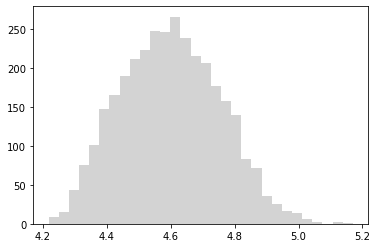

In [1093]:
total_UMIs = U.sum(0)+S.sum(0)
plt.hist(np.log10(total_UMIs),30,color='lightgray')

In [1090]:
1e5

100000.0

In [1094]:
cf = np.log10(total_UMIs)<5
U=U[:,cf]
S=S[:,cf]

In [1095]:
cf.sum()

3318

In [1096]:
n_cores = 20

In [1097]:
gene_inds_kept

[array([  85,  116,  161,  417,  449,  482,  687,  762,  781,  960, 1145,
        1292, 1303, 1351, 1355, 1404, 1496, 1555, 1633, 1664, 1813, 1988,
        2069, 2308, 2491, 2558, 2577, 2587, 2606, 2648, 2691, 2895, 2967]),
 array([  44,  146,  180,  314,  639,  715,  837,  887, 1756, 1809, 1826,
        1949, 2429, 2748, 2878]),
 array([ 227,  692,  708,  805,  926,  945, 1053, 1425, 1610, 1619, 1886,
        2073, 2076, 2127, 2158, 2343, 2487, 2545, 2768, 2913, 2973])]

In [1113]:
genes_to_run = [x[:5] for x in gene_inds_kept]
genes_to_run = [x for x in gene_inds_kept]

In [1114]:
genes_to_run[0]

array([  85,  116,  161,  417,  449,  482,  687,  762,  781,  960, 1145,
       1292, 1303, 1351, 1355, 1404, 1496, 1555, 1633, 1664, 1813, 1988,
       2069, 2308, 2491, 2558, 2577, 2587, 2606, 2648, 2691, 2895, 2967])

In [1115]:
model_set = 0
try:
    gtr = genes_to_run[model_set]
    gene_locations = [np.where(loom_gene_names==x)[0][0] for x in gn[gtr]]
    n_genes_to_run = len(gtr)
    pool = multiprocessing.Pool(processes=n_cores)
    fit_iterable = zip(U[gene_locations],\
                       S[gene_locations],\
                       [1]*n_genes_to_run,\
                       [10]*n_genes_to_run)
    gou_results_test = pool.map(par_fun_fullfit, fit_iterable)
    pool.close()
    pool.join()
except:
    print('failed')
    pool.terminate()
    pool.join()


In [1076]:
# genes_to_run[model_set]

In [1077]:
# gn[gtr]

In [1078]:
# gtr = genes_to_run[0]
# gene_locations = [np.where(loom_gene_names==x)[0][0] for x in gn[gtr]]

In [1079]:
# loom_gene_names[gene_locations]

In [1080]:
# U.shape

In [1081]:
# fitit = list(zip(U[gene_locations],\
#                S[gene_locations],\
#                [5]*n_genes_to_run,\
#                [10]*n_genes_to_run))[2]
# par_fun_fullfit(fitit)

In [1082]:
# Um = U[gene_locations[0]].mean()
# Uv = U[gene_locations[0]].var()
# Sm = S[gene_locations[0]].mean()
# Sv = S[gene_locations[0]].var()

# beta = 1/Um #assuming <k>=1
# gamma = 1/Sm
# kappa = beta / ( (Sv - Sm)/(Uv - Um) * Um * (beta + gamma) / (Sm*beta) - 1) - gamma
# theta = (kappa+beta)/Um * (Uv - Um)


In [1083]:
# a = kappa/theta

In [1084]:
# np.asarray([beta,gamma,kappa,theta])/a

In [1086]:
# get_MoM(U[gene_locations[2]],S[gene_locations[2]])

In [1087]:
# fitit = list(zip(U[gene_locations],\
#                S[gene_locations],\
#                results[model_set]['par_initial_guess'][:n_genes_to_run],\
#                ['fast']*n_genes_to_run))[0]
# par_fun_fullfit(fitit)

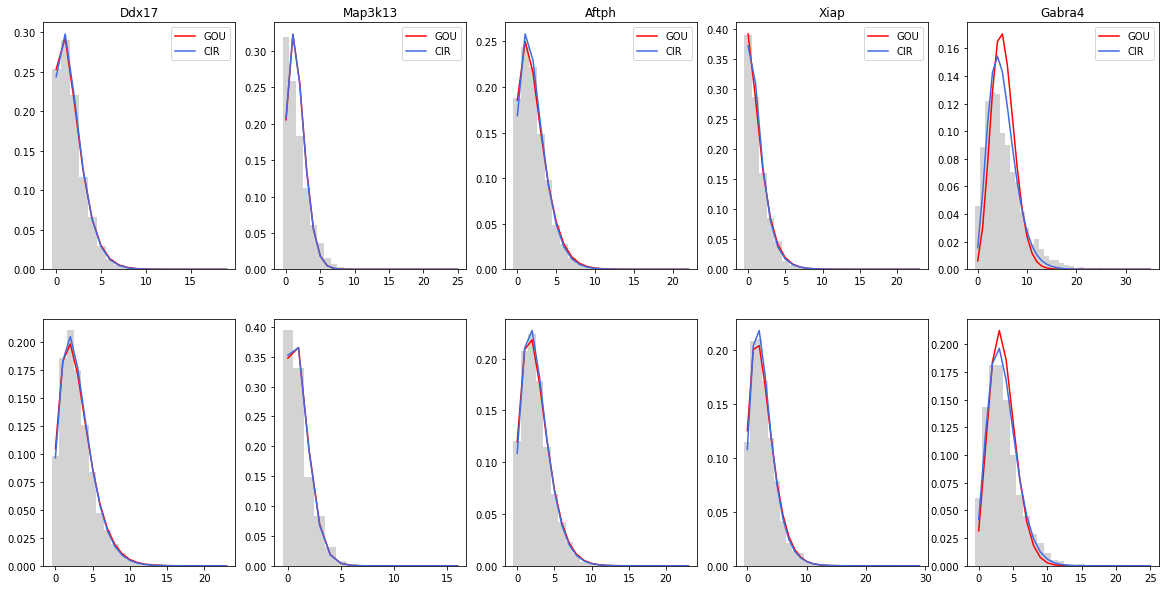

In [1116]:
fig1,ax1=plt.subplots(2,5,figsize=(20,10))

gou_reduced_color='lightcoral'
cir_reduced_color='skyblue'
gou_color='r'
cir_color='royalblue'

model_set=0
gtr = genes_to_run[model_set]
gene_locations = [np.where(loom_gene_names==x)[0][0] for x in gn[gtr]]


for k,gene_ind in enumerate(gene_locations[:5]):
    mx = np.asarray([U[gene_ind].max()+10,S[gene_ind].max()+10],dtype=int)

    bins = np.arange(mx[0]-8)-0.5
    ax1[0,k].hist(U[gene_ind],bins,color='lightgray',density=True)
    ax1[0,k].set_title(loom_gene_names[gene_ind])
    
    pars_sde_gou = gou_results_test[k][1]
    pars_sde_cir = gou_results_test[k][2]

    y = get_GOU_2sp([mx[0],1],pars_sde_gou)
    ax1[0,k].plot(y,'-',color=gou_color,label='GOU')
    y = get_CIR_2sp([mx[0],1],pars_sde_cir)
    ax1[0,k].plot(y,'-',color=cir_color,label='CIR')
    ax1[0,k].legend()

    bins = np.arange(mx[1]-8)-0.5
    ax1[1,k].hist(S[gene_ind],bins,color='lightgray',density=True)

    y = get_GOU_2sp([1,mx[1]],pars_sde_gou).squeeze()
    ax1[1,k].plot(y,'-',color=gou_color)
    y = get_CIR_2sp([1,mx[1]],pars_sde_cir).squeeze()
    ax1[1,k].plot(y,'-',color=cir_color)


In [1104]:
model_set = 1
try:
    gtr = genes_to_run[model_set]
    gene_locations = [np.where(loom_gene_names==x)[0][0] for x in gn[gtr]]
    n_genes_to_run = len(genes_to_run)
    pool = multiprocessing.Pool(processes=n_cores)
    fit_iterable = zip(U[gene_locations],\
                       S[gene_locations],\
                       [1]*n_genes_to_run,\
                       [10]*n_genes_to_run)
    cir_results_test = pool.map(par_fun_fullfit, fit_iterable)
    pool.close()
    pool.join()
except:
    print('failed')
    pool.terminate()
    pool.join()


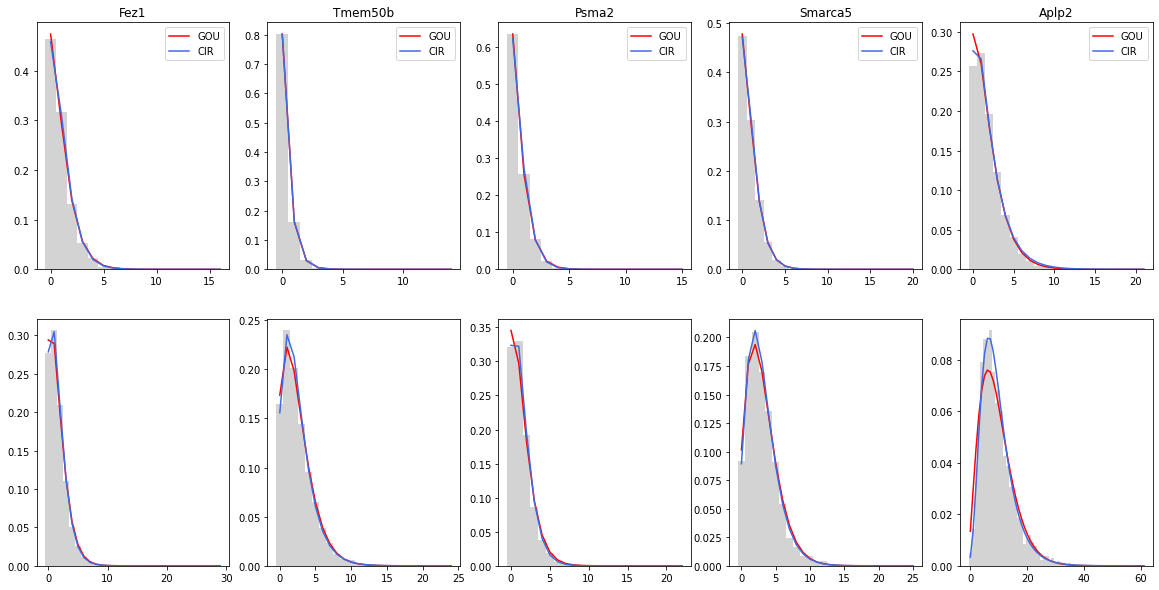

In [1105]:
fig1,ax1=plt.subplots(2,5,figsize=(20,10))

model_set=1
genes_to_run = gene_inds_kept[model_set]
gene_locations = [np.where(loom_gene_names==x)[0][0] for x in gn[genes_to_run]]


gou_reduced_color='lightcoral'
cir_reduced_color='skyblue'
gou_color='r'
cir_color='royalblue'

for k,gene_ind in enumerate(gene_locations[:5]):
    mx = np.asarray([U[gene_ind].max()+10,S[gene_ind].max()+10],dtype=int)

    bins = np.arange(mx[0]-8)-0.5
    ax1[0,k].hist(U[gene_ind],bins,color='lightgray',density=True)
    ax1[0,k].set_title(loom_gene_names[gene_ind])
    
    pars_sde_gou = cir_results_test[k][1]
    pars_sde_cir = cir_results_test[k][2]

    y = get_GOU_2sp([mx[0],1],pars_sde_gou)
    ax1[0,k].plot(y,'-',color=gou_color,label='GOU')
    y = get_CIR_2sp([mx[0],1],pars_sde_cir)
    ax1[0,k].plot(y,'-',color=cir_color,label='CIR')
    ax1[0,k].legend()

    bins = np.arange(mx[1]-8)-0.5
    ax1[1,k].hist(S[gene_ind],bins,color='lightgray',density=True)

    y = get_GOU_2sp([1,mx[1]],pars_sde_gou).squeeze()
    ax1[1,k].plot(y,'-',color=gou_color)
    y = get_CIR_2sp([1,mx[1]],pars_sde_cir).squeeze()
    ax1[1,k].plot(y,'-',color=cir_color)


In [1106]:
model_set = 2
try:
    gtr = genes_to_run[model_set]
    gene_locations = [np.where(loom_gene_names==x)[0][0] for x in gn[gtr]]
    n_genes_to_run = len(genes_to_run)
    pool = multiprocessing.Pool(processes=n_cores)
    fit_iterable = zip(U[gene_locations],\
                       S[gene_locations],\
                       [1]*n_genes_to_run,\
                       [10]*n_genes_to_run)
    ext_results_test = pool.map(par_fun_fullfit, fit_iterable)
    pool.close()
    pool.join()
except:
    print('failed')
    pool.terminate()
    pool.join()


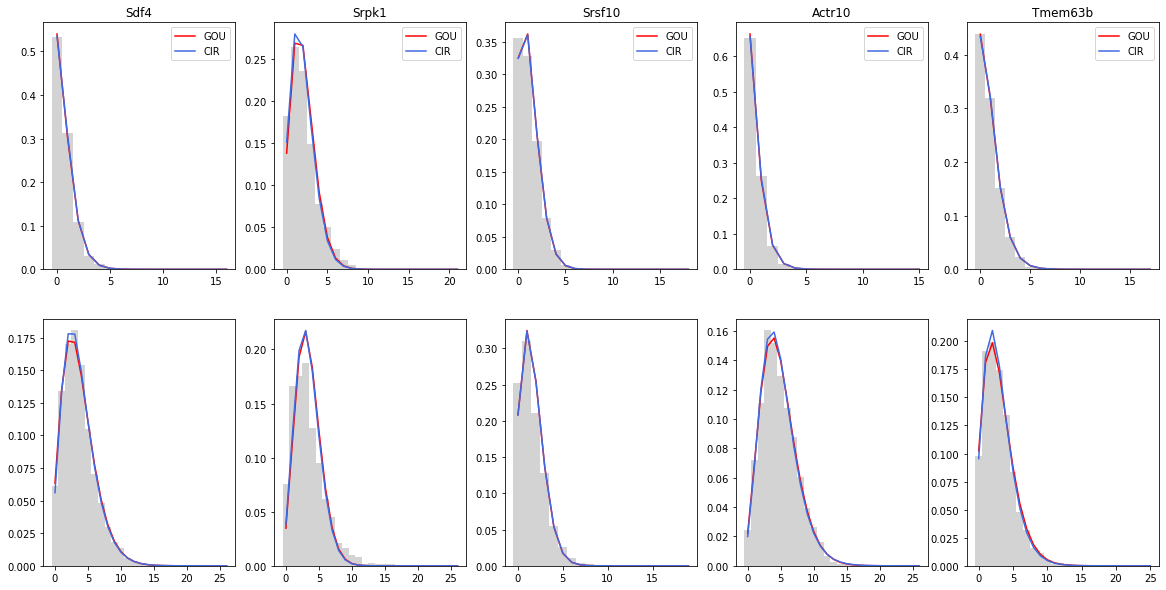

In [1107]:
fig1,ax1=plt.subplots(2,5,figsize=(20,10))
model_set=2
genes_to_run = gene_inds_kept[model_set]
gene_locations = [np.where(loom_gene_names==x)[0][0] for x in gn[genes_to_run]]

gou_reduced_color='lightcoral'
cir_reduced_color='skyblue'
gou_color='r'
cir_color='royalblue'

for k,gene_ind in enumerate(gene_locations[:5]):
    mx = np.asarray([U[gene_ind].max()+10,S[gene_ind].max()+10],dtype=int)
#     print(mx)

    bins = np.arange(mx[0]-8)-0.5
    ax1[0,k].hist(U[gene_ind],bins,color='lightgray',density=True)
    ax1[0,k].set_title(loom_gene_names[gene_ind])
    
    pars_sde_gou = ext_results_test[k][1]
    pars_sde_cir = ext_results_test[k][2]

    y = get_GOU_2sp([mx[0],1],pars_sde_gou)
    ax1[0,k].plot(y,'-',color=gou_color,label='GOU')
    y = get_CIR_2sp([mx[0],1],pars_sde_cir)
    ax1[0,k].plot(y,'-',color=cir_color,label='CIR')
    ax1[0,k].legend()

    bins = np.arange(mx[1]-8)-0.5
    ax1[1,k].hist(S[gene_ind],bins,color='lightgray',density=True)

    y = get_GOU_2sp([1,mx[1]],pars_sde_gou).squeeze()
    ax1[1,k].plot(y,'-',color=gou_color)
    y = get_CIR_2sp([1,mx[1]],pars_sde_cir).squeeze()
    ax1[1,k].plot(y,'-',color=cir_color)


In [1117]:
lik_ratios_test = [x[0] for x in gou_results_test] + [x[0] for x in cir_results_test] + [x[0] for x in ext_results_test] 

In [1118]:
colors = ['k']*len(gou_results_test) + ['b']*len(cir_results_test) + ['g']*len(ext_results_test)

(-100.0, 100.0)

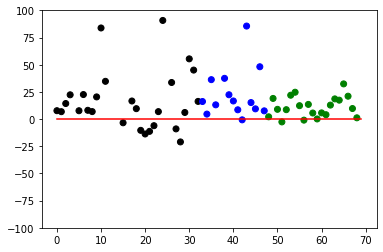

In [1119]:
plt.scatter(range(len(lik_ratios_test)),lik_ratios_test,color=colors)
plt.plot([0,len(lik_ratios_test)],[0,0],'r-')
plt.ylim([-100,100])

In [1120]:
lik_ratios_test

[7.72105727285998,
 6.810173459287398,
 14.312122459081365,
 22.333598149807585,
 932.3403535063626,
 7.680938496272574,
 22.568180641388608,
 8.079140588817609,
 6.888274379407449,
 20.393843703586754,
 83.80570244158662,
 34.73125677266398,
 -136.16996705380552,
 -222.68177768377063,
 -540.3706391576052,
 -3.3960317311375547,
 313.4579605760864,
 16.637272996191314,
 9.589947460270196,
 -10.362078882368223,
 -13.705297189482735,
 -11.291369203523573,
 -6.076023133649869,
 6.859274254153206,
 90.72052168455775,
 686.6689101268694,
 33.655304685032206,
 -9.017056333228538,
 -21.01335935341376,
 6.080175650185993,
 55.39673145717097,
 45.06477726488629,
 16.25486396420274,
 16.15337873649878,
 4.589969131793623,
 36.272693466547935,
 13.104795117871618,
 108.89536361677165,
 37.4806148134212,
 22.383820720689982,
 16.653296833150307,
 8.543148165445018,
 -0.6926291460586071,
 85.56215575681563,
 15.199928567129973,
 9.413097815144283,
 48.13356606174057,
 7.576091924256616,
 2.096803268

In [1112]:
with open('/home/ggorin/projects/GVFP_2021/fits/gg_220802_022_allen_celltypes_1/logl_fit_results.pickle','wb') as rfs:
    pickle.dump((gou_results_test,cir_results_test,ext_results_test),rfs)

In [698]:
model_gou = CMEModel('Bursty','None')
model_cir = CMEModel('CIR','None')

In [707]:
reduced_guess = results[0]['par_initial_guess'][0]
pars_sde_gou = convert_pars(get_MLE('GOU',sd_arr[dataset],gene_ind,reduced_guess,disp=False))
pars_sde_cir = convert_pars(get_MLE('CIR',sd_arr[dataset],gene_ind,reduced_guess,disp=False))

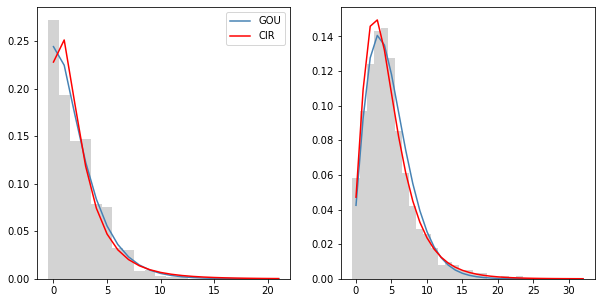

In [711]:
fig1,ax1=plt.subplots(1,2,figsize=(10,5))

# pars = results[0]['pars'][0,0]
# raw_pars = 10**pars
# pars_sde = np.zeros(5)
# pars_sde[0] = raw_pars[1]
# pars_sde[1] = raw_pars[2]
# pars_sde[2] = 1
# pars_sde[3] = 10
# pars_sde[4] = raw_pars[0]*pars_sde[3]
# print(mx)


gou_reduced_color='skyblue'
cir_reduced_color='lightcoral'
gou_color='steelblue'
cir_color='red'

bins = np.arange(mx[0]-8)-0.5
ax1[0].hist(sd_arr[dataset].U[gene_ind],bins,color='lightgray',density=True)

# print(reduced_guess)
# print(mx)
y = get_GOU_2sp([mx[0],1],pars_sde_gou)
ax1[0].plot(y,'-',color=gou_color,label='GOU')
y = get_CIR_2sp([mx[0],1],pars_sde_cir)
ax1[0].plot(y,'-',color=cir_color,label='CIR')
ax1[0].legend()

# y = model_gou.eval_model_pss(results[0]['pars'][0,0],[mx[0],1])
# ax1[0].plot(y,'-',color=gou_reduced_color)
# y = model_cir.eval_model_pss(results[0]['pars'][0,0],[mx[0],1])
# ax1[0].plot(y,'-',color=cir_reduced_color)

bins = np.arange(mx[1]-8)-0.5
ax1[1].hist(sd_arr[dataset].S[gene_ind],bins,color='lightgray',density=True)

y = get_GOU_2sp([1,mx[1]],pars_sde_gou).squeeze()
ax1[1].plot(y,'-',color=gou_color)
y = get_CIR_2sp([1,mx[1]],pars_sde_cir).squeeze()
ax1[1].plot(y,'-',color=cir_color)

# y = model_gou.eval_model_pss(results[0]['pars'][0,0],[1,mx[1]])
# ax1[1].plot(y,'-',color=gou_reduced_color)
# y = model_cir.eval_model_pss(results[0]['pars'][0,0],[1,mx[1]])
# ax1[1].plot(y,'-',color=cir_reduced_color)



In [709]:
pars_sde_gou

array([0.69846587, 0.34059974, 1.        , 5.33865792, 8.58307563])

In [710]:
pars_sde_cir

array([1.11828597, 0.55709416, 1.        , 3.70344119, 9.69163971])

In [718]:
lik_ratio, logL_gou, logL_cir = get_lik_ratio(pars_sde_gou,pars_sde_cir,sd_arr[dataset],gene_ind)

In [723]:
np.exp(lik_ratio)

0.0008416052667578937

In [724]:
# logL_cir

In [806]:
results[2]['par_initial_guess']

array([[ 0.61372314,  0.71400019, -0.0534286 ],
       [ 0.49207032,  0.28764252, -0.13998206],
       [ 0.51649076,  0.33332578,  0.259165  ],
       [ 0.65798982,  0.90407471, -0.06664039],
       [ 0.50257677,  0.43672378, -0.08166862],
       [ 0.56896899,  0.32475503, -0.04905389],
       [ 0.57303585,  0.45543787, -0.22442979],
       [ 0.57096672,  0.3093385 , -0.05130626],
       [ 0.59825045,  0.57515689, -0.09370603],
       [ 0.60444444,  1.11465733, -0.27654753],
       [ 0.6247251 ,  0.85859456, -0.50929776],
       [ 0.57455281,  0.46505862, -0.04826072],
       [ 0.63296907,  0.6880956 , -0.21616537],
       [ 0.4161751 , -0.05985304, -0.10934765],
       [ 0.61699898,  0.91419371, -0.2923707 ],
       [ 0.25186238,  0.25695717, -0.21070212],
       [ 0.66102217,  0.78704108, -0.65377645],
       [ 0.60307264,  0.05641369,  0.05646185],
       [ 0.56458335,  0.75621751, -0.41151128],
       [ 0.52427475,  0.90574789, -0.17088431],
       [ 0.4134201 ,  0.25317057, -0.036